# Analysis of DNA-MERFISH for CTP11

by Pu Zheng

2021.12.10

analysis for dataset:

\\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216

This data is DNA of smFISH RNA:
    \\10.245.74.158\Chromatin_NAS_6\20211216-P_brain_CTP12-RNA



In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

creating new log file
2022-01-07 13:39:19,427 [INFO] WRITING LOG OUTPUT TO C:\Users\puzheng\.cellpose\run.log
15516


# 0. fov parameters

In [2]:
dna_fov_param = {'data_folder':[r'\\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216',
                            r'\\10.245.74.158\Chromatin_NAS_6\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216',],
             'save_folder':r'M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216',
             'experiment_type': 'DNA',
             'num_threads': 16,
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50',
             'shared_parameters':{
                     'single_im_size':[50,2048,2048],
                     'distance_zxy': [250, 108, 108],
                     'corr_channels':['750','647'],
                     'num_empty_frames': 0, 
                     'num_buffer_frames':0,
                     'corr_hot_pixel':True,
                     'corr_Z_shift':True,
                     'corr_bleed':True,
                     'min_num_seeds':10,
                     'max_num_seeds': None,
                     'spot_seeding_th': 2500,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                     'corr_gaussian_highpass':True
                 }, 
             }

rna_fov_param = {
    'data_folder':r'\\10.245.74.158\Chromatin_NAS_6\20211216-P_brain_CTP12-RNA',
    #'save_folder':r'\\crick\Shiwei_Crick_4\Analyzed_Data\20211216-P_brain_CTP12-RNA',
    'save_folder': r'P:\Analyzed_Data\20211216-P_brain_CTP12-RNA',
    'experiment_type': 'RNA',
    'num_threads': 16,
    'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50',
    'shared_parameters':{
        'single_im_size':[50,2048,2048],
        'distance_zxy': [250, 108, 108],
        'corr_channels':['750','647'],
        'num_empty_frames': 0, 
        'num_buffer_frames':0,
        'corr_hot_pixel':True,
        'corr_Z_shift':True,
        'corr_bleed':True,
        'min_num_seeds':100,
        'max_num_seeds': None,
        'spot_seeding_th': 1500,
        'normalize_intensity_local':False,
        'normalize_intensity_background':False,
        'corr_gaussian_highpass':True,
        }, 
    }

## Load rotation alignment

In [3]:
reload(ia.correction_tools.alignment)
rna_align_file = r'\\10.245.74.158\Chromatin_NAS_6\20211216-P_brain_CTP12-RNA\Experiments\10x_positions_before.txt'
dna_align_file = r'\\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Alignments\10x_positions_after.txt'
print(os.path.exists(rna_align_file), os.path.exists(dna_align_file))

R, t = ia.correction_tools.alignment.align_manual_points(rna_align_file, dna_align_file,
                                                         save_folder=None)

True True
- Manually picked points aligned, rotation:
[[ 0.99987138  0.01603818]
 [-0.01603818  0.99987138]],
 translation:[-2132.35179369 -1145.97222401]
-- rotation matrix saved to file:\\10.245.74.158\Chromatin_NAS_6\20211216-P_brain_CTP12-RNA\Experiments\rotation
-- translation matrix saved to file:\\10.245.74.158\Chromatin_NAS_6\20211216-P_brain_CTP12-RNA\Experiments\translation


# Batch

In [31]:
import math
_dz,_dx,_dy = np.shape(seg_labels)
_rotation_angle = np.arcsin(R[0,1])/math.pi*180
_rotation_M = cv2.getRotationMatrix2D((_dx/2, _dy/2), _rotation_angle, 1)

In [58]:
rot_labels = np.array([cv2.warpAffine(_seg_layer, _rotation_M, _seg_layer.shape, flags=cv2.INTER_NEAREST,
                                              borderMode=cv2.BORDER_CONSTANT) for _seg_layer in seg_labels])

In [77]:
reload(ia.segmentation_tools.cell)
reload(ia.correction_tools.translate)

new_label = segmentation_tools.cell.translate_segmentation(rna_fov.dapi_im, dna_fov.dapi_im,
                                               R,  seg_labels)

-- start calculating drift with rotation between images
-- aligning image -> directly use image
-- directly use ref_image
--- drift: [4.61 0.29 2.45] pixels


In [78]:
new_label.shape

(50, 2048, 2048)

In [75]:
reload(ia.segmentation_tools.cell)
reload(ia.correction_tools.translate)


<module 'ImageAnalysis3.correction_tools.translate' from '..\\..\\..\\..\\Documents\\ImageAnalysis3\\correction_tools\\translate.py'>

In [81]:
#reload(ia.meta_tools.partition_spots)
from ImageAnalysis3.meta_tools.partition_spots import Spots_Partition
from ImageAnalysis3.classes.preprocess import Spots3D
dapi_th = 10000

cand_spot_folder = os.path.join(dna_fov_param['save_folder'], 'CandSpots')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(cand_spot_folder)

sel_fov_ids = np.arange(25,120)
    
for _fov_id in sel_fov_ids:

    dna_fov = classes.field_of_view.Field_of_View(dna_fov_param, _fov_id=_fov_id,
                                                  _color_info_kwargs={
                                                      '_color_filename':'Color_Usage',
                                                  }, 
                                                  _prioritize_saved_attrs=False,
                                                  _save_info_to_file=False,
                                                  )

    # create rna_fov class
    rna_fov = classes.field_of_view.Field_of_View(rna_fov_param, _fov_id=_fov_id,
                                              _color_info_kwargs={
                                                  '_color_filename':'Color_Usage',
                                              }, 
                                              _prioritize_saved_attrs=False,
                                              _save_info_to_file=False,
                                              )
    
    # Load DAPI
    dna_dapi_im = dna_fov._load_dapi_image()
    rna_dapi_im = rna_fov._load_dapi_image()
    
    # align dapi images
    segmentation_filename = os.path.join(rna_fov.save_folder, 'Segmentation', 
                                     os.path.basename(dna_fov.save_filename).replace('.hdf5', '_Segmentation.npy'))
    seg_labels = np.load(segmentation_filename)

    new_label = segmentation_tools.cell.translate_segmentation(rna_fov.dapi_im, dna_fov.dapi_im,
                                                   R,  seg_labels)
    
    
    # partition spots into cells
    dna_fov._load_from_file('combo')

    pixel_sizes = dna_fov.shared_parameters['distance_zxy']
    single_im_size = dna_fov.shared_parameters['single_im_size']

    all_spots_list = [Spots3D(_spots, bits=_id, pixel_sizes=pixel_sizes) for _spots, _id in zip(dna_fov.combo_spots_list, dna_fov.combo_ids)]

    sp = Spots_Partition(new_label, "", 
                         search_radius=10, pixel_sizes=pixel_sizes,
                         save_filename=None)

    cell_2_spots = {_c:{} for _c in np.unique(new_label)[np.unique(new_label)>0]}

    for _spots, _id in zip(all_spots_list, dna_fov.combo_ids):
        _labels = sp.spots_to_labels(sp.segmentation_masks, _spots, sp.image_size)

        _signals = sp.spots_to_DAPI(dna_fov.dapi_im, _spots, single_im_size, search_radius=5)

        for _l in np.unique(_labels):
            if _l > 0:
                cell_2_spots[_l][_id] = _spots[(_labels==_l) * (_signals > dapi_th)]
                cell_2_spots[_l][_id].bits = _spots.bits[(_labels==_l) * (_signals > dapi_th)]
    # save spots
    for _cell_id, _spots_list in cell_2_spots.items():
        _cand_filename = os.path.join(cand_spot_folder, os.path.basename(dna_fov.save_filename).replace('.hdf5', f'_Cell-{_cell_id}_CandSpots.pkl') )
        print(_cand_filename)
        pickle.dump(_spots_list, open(_cand_filename, 'wb'))

M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 34
- Number of field of views: 211
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H5

- partition barcodes for 8836 spots
- calculate local DAPI signal for 8836 spots
- partition barcodes for 6633 spots
- calculate local DAPI signal for 6633 spots
- partition barcodes for 9064 spots
- calculate local DAPI signal for 9064 spots
- partition barcodes for 5391 spots
- calculate local DAPI signal for 5391 spots
- partition barcodes for 9102 spots
- calculate local DAPI signal for 9102 spots
- partition barcodes for 5395 spots
- calculate local DAPI signal for 5395 spots
- partition barcodes for 9076 spots
- calculate local DAPI signal for 9076 spots
- partition barcodes for 6196 spots
- calculate local DAPI signal for 6196 spots
- partition barcodes for 9492 spots
- calculate local DAPI signal for 9492 spots
- partition barcodes for 6281 spots
- calculate local DAPI signal for 6281 spots
- partition barcodes for 8980 spots
- calculate local DAPI signal for 8980 spots
- partition barcodes for 6827 spots
- calculate local DAPI signal for 6827 spots
- partition barcodes for 975

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12', 'H62U13', 'H63U14'])
- 64 folders are found according to color-usage annotation.
+ loading fov_info f

- partition barcodes for 9442 spots
- calculate local DAPI signal for 9442 spots
- partition barcodes for 5649 spots
- calculate local DAPI signal for 5649 spots
- partition barcodes for 9426 spots
- calculate local DAPI signal for 9426 spots
- partition barcodes for 5664 spots
- calculate local DAPI signal for 5664 spots
- partition barcodes for 9477 spots
- calculate local DAPI signal for 9477 spots
- partition barcodes for 6151 spots
- calculate local DAPI signal for 6151 spots
- partition barcodes for 9428 spots
- calculate local DAPI signal for 9428 spots
- partition barcodes for 6749 spots
- calculate local DAPI signal for 6749 spots
- partition barcodes for 9640 spots
- calculate local DAPI signal for 9640 spots
- partition barcodes for 7306 spots
- calculate local DAPI signal for 7306 spots
- partition barcodes for 10138 spots
- calculate local DAPI signal for 10138 spots
- partition barcodes for 6719 spots
- calculate local DAPI signal for 6719 spots
- partition barcodes for 1

- Number of field of views: 211
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12', 'H62U13', 'H63U14'])
- 64 folders are found according to color-usage 

- calculate local DAPI signal for 7013 spots
- partition barcodes for 9741 spots
- calculate local DAPI signal for 9741 spots
- partition barcodes for 5749 spots
- calculate local DAPI signal for 5749 spots
- partition barcodes for 9608 spots
- calculate local DAPI signal for 9608 spots
- partition barcodes for 5757 spots
- calculate local DAPI signal for 5757 spots
- partition barcodes for 9645 spots
- calculate local DAPI signal for 9645 spots
- partition barcodes for 6012 spots
- calculate local DAPI signal for 6012 spots
- partition barcodes for 9615 spots
- calculate local DAPI signal for 9615 spots
- partition barcodes for 6761 spots
- calculate local DAPI signal for 6761 spots
- partition barcodes for 9815 spots
- calculate local DAPI signal for 9815 spots
- partition barcodes for 7307 spots
- calculate local DAPI signal for 7307 spots
- partition barcodes for 10297 spots
- calculate local DAPI signal for 10297 spots
- partition barcodes for 7024 spots
- calculate local DAPI sig

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12', 'H62U13', 'H63U14'])
- 64 folders are found according to color-usage annotation.
+ loading fov_info f

- partition barcodes for 9375 spots
- calculate local DAPI signal for 9375 spots
- partition barcodes for 5770 spots
- calculate local DAPI signal for 5770 spots
- partition barcodes for 9467 spots
- calculate local DAPI signal for 9467 spots
- partition barcodes for 5690 spots
- calculate local DAPI signal for 5690 spots
- partition barcodes for 9519 spots
- calculate local DAPI signal for 9519 spots
- partition barcodes for 6054 spots
- calculate local DAPI signal for 6054 spots
- partition barcodes for 9356 spots
- calculate local DAPI signal for 9356 spots
- partition barcodes for 6761 spots
- calculate local DAPI signal for 6761 spots
- partition barcodes for 9655 spots
- calculate local DAPI signal for 9655 spots
- partition barcodes for 7249 spots
- calculate local DAPI signal for 7249 spots
- partition barcodes for 9921 spots
- calculate local DAPI signal for 9921 spots
- partition barcodes for 6695 spots
- calculate local DAPI signal for 6695 spots
- partition barcodes for 101

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12', 'H62U13', 'H63U14'])
- 64 folders are found according to color-usage annotation.
+ loading fov_info f

- partition barcodes for 9722 spots
- calculate local DAPI signal for 9722 spots
- partition barcodes for 5594 spots
- calculate local DAPI signal for 5594 spots
- partition barcodes for 9517 spots
- calculate local DAPI signal for 9517 spots
- partition barcodes for 5658 spots
- calculate local DAPI signal for 5658 spots
- partition barcodes for 9656 spots
- calculate local DAPI signal for 9656 spots
- partition barcodes for 6330 spots
- calculate local DAPI signal for 6330 spots
- partition barcodes for 9786 spots
- calculate local DAPI signal for 9786 spots
- partition barcodes for 6914 spots
- calculate local DAPI signal for 6914 spots
- partition barcodes for 9899 spots
- calculate local DAPI signal for 9899 spots
- partition barcodes for 7357 spots
- calculate local DAPI signal for 7357 spots
- partition barcodes for 10162 spots
- calculate local DAPI signal for 10162 spots
- partition barcodes for 6947 spots
- calculate local DAPI signal for 6947 spots
- partition barcodes for 1

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12', 'H62U13', 'H63U14'])
- 64 folders are found according to color-usage annotation.
+ loading fov_info f

- partition barcodes for 9976 spots
- calculate local DAPI signal for 9976 spots
- partition barcodes for 5998 spots
- calculate local DAPI signal for 5998 spots
- partition barcodes for 9931 spots
- calculate local DAPI signal for 9931 spots
- partition barcodes for 5983 spots
- calculate local DAPI signal for 5983 spots
- partition barcodes for 10066 spots
- calculate local DAPI signal for 10066 spots
- partition barcodes for 6834 spots
- calculate local DAPI signal for 6834 spots
- partition barcodes for 10005 spots
- calculate local DAPI signal for 10005 spots
- partition barcodes for 7277 spots
- calculate local DAPI signal for 7277 spots
- partition barcodes for 10306 spots
- calculate local DAPI signal for 10306 spots
- partition barcodes for 7564 spots
- calculate local DAPI signal for 7564 spots
- partition barcodes for 10679 spots
- calculate local DAPI signal for 10679 spots
- partition barcodes for 7340 spots
- calculate local DAPI signal for 7340 spots
- partition barcodes

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 34
- Number of field of views: 211
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12

- calculate local DAPI signal for 11425 spots
- partition barcodes for 8372 spots
- calculate local DAPI signal for 8372 spots
- partition barcodes for 11440 spots
- calculate local DAPI signal for 11440 spots
- partition barcodes for 6645 spots
- calculate local DAPI signal for 6645 spots
- partition barcodes for 11097 spots
- calculate local DAPI signal for 11097 spots
- partition barcodes for 6948 spots
- calculate local DAPI signal for 6948 spots
- partition barcodes for 11445 spots
- calculate local DAPI signal for 11445 spots
- partition barcodes for 7646 spots
- calculate local DAPI signal for 7646 spots
- partition barcodes for 11591 spots
- calculate local DAPI signal for 11591 spots
- partition barcodes for 8116 spots
- calculate local DAPI signal for 8116 spots
- partition barcodes for 11664 spots
- calculate local DAPI signal for 11664 spots
- partition barcodes for 8582 spots
- calculate local DAPI signal for 8582 spots
- partition barcodes for 11976 spots
- calculate loca

M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_031_Cell-138_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_031_Cell-139_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_031_Cell-140_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_031_Cell-141_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_031_Cell-142_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_031_Cell-143_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_031_Cell-144_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_031_Cell-145_CandSpots.pkl
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 34
- Number of field of views: 211
Get Folder Names: (ia.get_img_info.get_f

- partition barcodes for 14528 spots
- calculate local DAPI signal for 14528 spots
- partition barcodes for 10213 spots
- calculate local DAPI signal for 10213 spots
- partition barcodes for 13986 spots
- calculate local DAPI signal for 13986 spots
- partition barcodes for 7356 spots
- calculate local DAPI signal for 7356 spots
- partition barcodes for 11814 spots
- calculate local DAPI signal for 11814 spots
- partition barcodes for 6272 spots
- calculate local DAPI signal for 6272 spots
- partition barcodes for 8300 spots
- calculate local DAPI signal for 8300 spots
- partition barcodes for 7049 spots
- calculate local DAPI signal for 7049 spots
- partition barcodes for 11129 spots
- calculate local DAPI signal for 11129 spots
- partition barcodes for 6895 spots
- calculate local DAPI signal for 6895 spots
- partition barcodes for 10328 spots
- calculate local DAPI signal for 10328 spots
- partition barcodes for 7688 spots
- calculate local DAPI signal for 7688 spots
- partition barc

- Number of folders: 34
- Number of field of views: 211
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12', 'H62U13', 'H63U14'])
- 64 folders are found a

- calculate local DAPI signal for 6537 spots
- partition barcodes for 9061 spots
- calculate local DAPI signal for 9061 spots
- partition barcodes for 5208 spots
- calculate local DAPI signal for 5208 spots
- partition barcodes for 8814 spots
- calculate local DAPI signal for 8814 spots
- partition barcodes for 5366 spots
- calculate local DAPI signal for 5366 spots
- partition barcodes for 9031 spots
- calculate local DAPI signal for 9031 spots
- partition barcodes for 5538 spots
- calculate local DAPI signal for 5538 spots
- partition barcodes for 8823 spots
- calculate local DAPI signal for 8823 spots
- partition barcodes for 6216 spots
- calculate local DAPI signal for 6216 spots
- partition barcodes for 9245 spots
- calculate local DAPI signal for 9245 spots
- partition barcodes for 6734 spots
- calculate local DAPI signal for 6734 spots
- partition barcodes for 9478 spots
- calculate local DAPI signal for 9478 spots
- partition barcodes for 6267 spots
- calculate local DAPI signa

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12', 'H62U13', 'H63U14'])
- 64 folders are found according to color-usage annotation.
+ loading fov_info f

- partition barcodes for 9451 spots
- calculate local DAPI signal for 9451 spots
- partition barcodes for 5398 spots
- calculate local DAPI signal for 5398 spots
- partition barcodes for 9176 spots
- calculate local DAPI signal for 9176 spots
- partition barcodes for 5562 spots
- calculate local DAPI signal for 5562 spots
- partition barcodes for 9248 spots
- calculate local DAPI signal for 9248 spots
- partition barcodes for 5824 spots
- calculate local DAPI signal for 5824 spots
- partition barcodes for 9122 spots
- calculate local DAPI signal for 9122 spots
- partition barcodes for 6520 spots
- calculate local DAPI signal for 6520 spots
- partition barcodes for 9569 spots
- calculate local DAPI signal for 9569 spots
- partition barcodes for 7041 spots
- calculate local DAPI signal for 7041 spots
- partition barcodes for 9843 spots
- calculate local DAPI signal for 9843 spots
- partition barcodes for 6659 spots
- calculate local DAPI signal for 6659 spots
- partition barcodes for 101

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12', 'H62U13', 'H63U14'])
- 64 folders are found according to color-usage annotation.
+ loading fov_info f

- partition barcodes for 7942 spots
- calculate local DAPI signal for 7942 spots
- partition barcodes for 4765 spots
- calculate local DAPI signal for 4765 spots
- partition barcodes for 7919 spots
- calculate local DAPI signal for 7919 spots
- partition barcodes for 4816 spots
- calculate local DAPI signal for 4816 spots
- partition barcodes for 8050 spots
- calculate local DAPI signal for 8050 spots
- partition barcodes for 5057 spots
- calculate local DAPI signal for 5057 spots
- partition barcodes for 7981 spots
- calculate local DAPI signal for 7981 spots
- partition barcodes for 5742 spots
- calculate local DAPI signal for 5742 spots
- partition barcodes for 8286 spots
- calculate local DAPI signal for 8286 spots
- partition barcodes for 6107 spots
- calculate local DAPI signal for 6107 spots
- partition barcodes for 8579 spots
- calculate local DAPI signal for 8579 spots
- partition barcodes for 5743 spots
- calculate local DAPI signal for 5743 spots
- partition barcodes for 873

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12', 'H62U13', 'H63U14'])
- 64 folders are found according to color-usage annotation.
+ loading fov_info f

- partition barcodes for 10673 spots
- calculate local DAPI signal for 10673 spots
- partition barcodes for 6731 spots
- calculate local DAPI signal for 6731 spots
- partition barcodes for 10960 spots
- calculate local DAPI signal for 10960 spots
- partition barcodes for 6687 spots
- calculate local DAPI signal for 6687 spots
- partition barcodes for 10746 spots
- calculate local DAPI signal for 10746 spots
- partition barcodes for 7463 spots
- calculate local DAPI signal for 7463 spots
- partition barcodes for 11042 spots
- calculate local DAPI signal for 11042 spots
- partition barcodes for 7889 spots
- calculate local DAPI signal for 7889 spots
- partition barcodes for 10873 spots
- calculate local DAPI signal for 10873 spots
- partition barcodes for 8547 spots
- calculate local DAPI signal for 8547 spots
- partition barcodes for 11365 spots
- calculate local DAPI signal for 11365 spots
- partition barcodes for 7971 spots
- calculate local DAPI signal for 7971 spots
- partition barc

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12', 'H62U13', 'H63U14'])
- 64 folders are found according to color-usage annotation.
+ loading fov_info f

- partition barcodes for 8279 spots
- calculate local DAPI signal for 8279 spots
- partition barcodes for 5254 spots
- calculate local DAPI signal for 5254 spots
- partition barcodes for 8614 spots
- calculate local DAPI signal for 8614 spots
- partition barcodes for 5042 spots
- calculate local DAPI signal for 5042 spots
- partition barcodes for 8555 spots
- calculate local DAPI signal for 8555 spots
- partition barcodes for 5957 spots
- calculate local DAPI signal for 5957 spots
- partition barcodes for 9242 spots
- calculate local DAPI signal for 9242 spots
- partition barcodes for 6021 spots
- calculate local DAPI signal for 6021 spots
- partition barcodes for 8386 spots
- calculate local DAPI signal for 8386 spots
- partition barcodes for 6589 spots
- calculate local DAPI signal for 6589 spots
- partition barcodes for 8994 spots
- calculate local DAPI signal for 8994 spots
- partition barcodes for 5781 spots
- calculate local DAPI signal for 5781 spots
- partition barcodes for 918

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12', 'H62U13', 'H63U14'])
- 64 folders are found according to color-usage annotation.
+ loading fov_info f

- calculate local DAPI signal for 7295 spots
- partition barcodes for 4399 spots
- calculate local DAPI signal for 4399 spots
- partition barcodes for 7259 spots
- calculate local DAPI signal for 7259 spots
- partition barcodes for 4251 spots
- calculate local DAPI signal for 4251 spots
- partition barcodes for 7256 spots
- calculate local DAPI signal for 7256 spots
- partition barcodes for 5343 spots
- calculate local DAPI signal for 5343 spots
- partition barcodes for 7919 spots
- calculate local DAPI signal for 7919 spots
- partition barcodes for 5066 spots
- calculate local DAPI signal for 5066 spots
- partition barcodes for 6934 spots
- calculate local DAPI signal for 6934 spots
- partition barcodes for 5467 spots
- calculate local DAPI signal for 5467 spots
- partition barcodes for 7471 spots
- calculate local DAPI signal for 7471 spots
- partition barcodes for 5109 spots
- calculate local DAPI signal for 5109 spots
- partition barcodes for 7962 spots
- calculate local DAPI signa

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12', 'H62U13', 'H63U14'])
- 64 folders are found according to color-usage annotation.
+ loading fov_info f

- calculate local DAPI signal for 7074 spots
- partition barcodes for 4411 spots
- calculate local DAPI signal for 4411 spots
- partition barcodes for 7344 spots
- calculate local DAPI signal for 7344 spots
- partition barcodes for 4328 spots
- calculate local DAPI signal for 4328 spots
- partition barcodes for 7298 spots
- calculate local DAPI signal for 7298 spots
- partition barcodes for 5020 spots
- calculate local DAPI signal for 5020 spots
- partition barcodes for 7747 spots
- calculate local DAPI signal for 7747 spots
- partition barcodes for 4978 spots
- calculate local DAPI signal for 4978 spots
- partition barcodes for 7316 spots
- calculate local DAPI signal for 7316 spots
- partition barcodes for 5524 spots
- calculate local DAPI signal for 5524 spots
- partition barcodes for 7739 spots
- calculate local DAPI signal for 7739 spots
- partition barcodes for 4986 spots
- calculate local DAPI signal for 4986 spots
- partition barcodes for 7842 spots
- calculate local DAPI signa

- 64 folders are found according to color-usage annotation.
+ loading fov_info from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_040.hdf5
++ base attributes loaded:['combo_ref_im', 'dapi_im', 'unique_ref_im'] in 6.891s.
+ loading correction from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_040.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_040.hdf5
++ base attributes loaded:[] in 0.007s.
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 14
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_6\20211216-P_brain_CTP12-RNA\Analysis\Color_Usage.csv
- h

- calculate local DAPI signal for 6594 spots
- partition barcodes for 9746 spots
- calculate local DAPI signal for 9746 spots
- partition barcodes for 7030 spots
- calculate local DAPI signal for 7030 spots
- partition barcodes for 10066 spots
- calculate local DAPI signal for 10066 spots
- partition barcodes for 6932 spots
- calculate local DAPI signal for 6932 spots
- partition barcodes for 7978 spots
- calculate local DAPI signal for 7978 spots
- partition barcodes for 4918 spots
- calculate local DAPI signal for 4918 spots
- partition barcodes for 7537 spots
- calculate local DAPI signal for 7537 spots
- partition barcodes for 7246 spots
- calculate local DAPI signal for 7246 spots
- partition barcodes for 9799 spots
- calculate local DAPI signal for 9799 spots
- partition barcodes for 7365 spots
- calculate local DAPI signal for 7365 spots
- partition barcodes for 9684 spots
- calculate local DAPI signal for 9684 spots
- partition barcodes for 7317 spots
- calculate local DAPI sig

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12', 'H62U13', 'H63U14'])
- 64 folders are found according to color-usage annotation.
+ loading fov_info f

- partition barcodes for 8505 spots
- calculate local DAPI signal for 8505 spots
- partition barcodes for 5097 spots
- calculate local DAPI signal for 5097 spots
- partition barcodes for 8422 spots
- calculate local DAPI signal for 8422 spots
- partition barcodes for 5115 spots
- calculate local DAPI signal for 5115 spots
- partition barcodes for 8560 spots
- calculate local DAPI signal for 8560 spots
- partition barcodes for 5555 spots
- calculate local DAPI signal for 5555 spots
- partition barcodes for 8391 spots
- calculate local DAPI signal for 8391 spots
- partition barcodes for 6159 spots
- calculate local DAPI signal for 6159 spots
- partition barcodes for 8860 spots
- calculate local DAPI signal for 8860 spots
- partition barcodes for 6622 spots
- calculate local DAPI signal for 6622 spots
- partition barcodes for 8995 spots
- calculate local DAPI signal for 8995 spots
- partition barcodes for 5977 spots
- calculate local DAPI signal for 5977 spots
- partition barcodes for 928

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12', 'H62U13', 'H63U14'])
- 64 folders are found according to color-usage annotation.
+ loading fov_info f

- partition barcodes for 10727 spots
- calculate local DAPI signal for 10727 spots
- partition barcodes for 6212 spots
- calculate local DAPI signal for 6212 spots
- partition barcodes for 10532 spots
- calculate local DAPI signal for 10532 spots
- partition barcodes for 6360 spots
- calculate local DAPI signal for 6360 spots
- partition barcodes for 10573 spots
- calculate local DAPI signal for 10573 spots
- partition barcodes for 6731 spots
- calculate local DAPI signal for 6731 spots
- partition barcodes for 10490 spots
- calculate local DAPI signal for 10490 spots
- partition barcodes for 7728 spots
- calculate local DAPI signal for 7728 spots
- partition barcodes for 11160 spots
- calculate local DAPI signal for 11160 spots
- partition barcodes for 8260 spots
- calculate local DAPI signal for 8260 spots
- partition barcodes for 11322 spots
- calculate local DAPI signal for 11322 spots
- partition barcodes for 7641 spots
- calculate local DAPI signal for 7641 spots
- partition barc

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 34
- Number of field of views: 211
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12

- calculate local DAPI signal for 12597 spots
- partition barcodes for 9464 spots
- calculate local DAPI signal for 9464 spots
- partition barcodes for 12658 spots
- calculate local DAPI signal for 12658 spots
- partition barcodes for 7484 spots
- calculate local DAPI signal for 7484 spots
- partition barcodes for 12441 spots
- calculate local DAPI signal for 12441 spots
- partition barcodes for 7626 spots
- calculate local DAPI signal for 7626 spots
- partition barcodes for 12668 spots
- calculate local DAPI signal for 12668 spots
- partition barcodes for 7979 spots
- calculate local DAPI signal for 7979 spots
- partition barcodes for 12266 spots
- calculate local DAPI signal for 12266 spots
- partition barcodes for 9245 spots
- calculate local DAPI signal for 9245 spots
- partition barcodes for 13018 spots
- calculate local DAPI signal for 13018 spots
- partition barcodes for 9732 spots
- calculate local DAPI signal for 9732 spots
- partition barcodes for 13191 spots
- calculate loca

M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_043_Cell-140_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_043_Cell-141_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_043_Cell-142_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_043_Cell-143_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_043_Cell-144_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_043_Cell-145_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_043_Cell-146_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_043_Cell-147_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_043_Cell-148_CandSpots.pkl
Get Folder Names: (ia.get_img_info.ge

- partition barcodes for 11212 spots
- calculate local DAPI signal for 11212 spots
- partition barcodes for 17010 spots
- calculate local DAPI signal for 17010 spots
- partition barcodes for 12250 spots
- calculate local DAPI signal for 12250 spots
- partition barcodes for 16260 spots
- calculate local DAPI signal for 16260 spots
- partition barcodes for 8728 spots
- calculate local DAPI signal for 8728 spots
- partition barcodes for 13933 spots
- calculate local DAPI signal for 13933 spots
- partition barcodes for 7488 spots
- calculate local DAPI signal for 7488 spots
- partition barcodes for 9932 spots
- calculate local DAPI signal for 9932 spots
- partition barcodes for 8539 spots
- calculate local DAPI signal for 8539 spots
- partition barcodes for 13087 spots
- calculate local DAPI signal for 13087 spots
- partition barcodes for 8399 spots
- calculate local DAPI signal for 8399 spots
- partition barcodes for 12158 spots
- calculate local DAPI signal for 12158 spots
- partition ba

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 34
- Number of field of views: 211
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12

- calculate local DAPI signal for 10702 spots
- partition barcodes for 7832 spots
- calculate local DAPI signal for 7832 spots
- partition barcodes for 10482 spots
- calculate local DAPI signal for 10482 spots
- partition barcodes for 6344 spots
- calculate local DAPI signal for 6344 spots
- partition barcodes for 10361 spots
- calculate local DAPI signal for 10361 spots
- partition barcodes for 6435 spots
- calculate local DAPI signal for 6435 spots
- partition barcodes for 10561 spots
- calculate local DAPI signal for 10561 spots
- partition barcodes for 7149 spots
- calculate local DAPI signal for 7149 spots
- partition barcodes for 10814 spots
- calculate local DAPI signal for 10814 spots
- partition barcodes for 7605 spots
- calculate local DAPI signal for 7605 spots
- partition barcodes for 11020 spots
- calculate local DAPI signal for 11020 spots
- partition barcodes for 8168 spots
- calculate local DAPI signal for 8168 spots
- partition barcodes for 11152 spots
- calculate loca

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 34
- Number of field of views: 211
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12

- calculate local DAPI signal for 10975 spots
- partition barcodes for 7942 spots
- calculate local DAPI signal for 7942 spots
- partition barcodes for 10616 spots
- calculate local DAPI signal for 10616 spots
- partition barcodes for 6501 spots
- calculate local DAPI signal for 6501 spots
- partition barcodes for 10610 spots
- calculate local DAPI signal for 10610 spots
- partition barcodes for 6654 spots
- calculate local DAPI signal for 6654 spots
- partition barcodes for 10907 spots
- calculate local DAPI signal for 10907 spots
- partition barcodes for 7570 spots
- calculate local DAPI signal for 7570 spots
- partition barcodes for 11144 spots
- calculate local DAPI signal for 11144 spots
- partition barcodes for 7802 spots
- calculate local DAPI signal for 7802 spots
- partition barcodes for 11271 spots
- calculate local DAPI signal for 11271 spots
- partition barcodes for 8276 spots
- calculate local DAPI signal for 8276 spots
- partition barcodes for 11486 spots
- calculate loca

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12', 'H62U13', 'H63U14'])
- 64 folders are found according to color-usage annotation.
+ loading fov_info f

- calculate local DAPI signal for 2534 spots
- partition barcodes for 1534 spots
- calculate local DAPI signal for 1534 spots
- partition barcodes for 2610 spots
- calculate local DAPI signal for 2610 spots
- partition barcodes for 1608 spots
- calculate local DAPI signal for 1608 spots
- partition barcodes for 2663 spots
- calculate local DAPI signal for 2663 spots
- partition barcodes for 1928 spots
- calculate local DAPI signal for 1928 spots
- partition barcodes for 3067 spots
- calculate local DAPI signal for 3067 spots
- partition barcodes for 1908 spots
- calculate local DAPI signal for 1908 spots
- partition barcodes for 3261 spots
- calculate local DAPI signal for 3261 spots
- partition barcodes for 1935 spots
- calculate local DAPI signal for 1935 spots
- partition barcodes for 2967 spots
- calculate local DAPI signal for 2967 spots
- partition barcodes for 1934 spots
- calculate local DAPI signal for 1934 spots
- partition barcodes for 3106 spots
- calculate local DAPI signa

directly return existing attribute.
directly return existing attribute.
-- start calculating drift with rotation between images
-- aligning image -> directly use image
-- directly use ref_image
--- drift: [-0.38  8.84  3.47] pixels
+ loading combo from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_048.hdf5
++ finish loading combo in 0.185s. 
- Partition spots
- partition barcodes for 2944 spots
- calculate local DAPI signal for 2944 spots
- partition barcodes for 6946 spots
- calculate local DAPI signal for 6946 spots
- partition barcodes for 3047 spots
- calculate local DAPI signal for 3047 spots
- partition barcodes for 5910 spots
- calculate local DAPI signal for 5910 spots
- partition barcodes for 3406 spots
- calculate local DAPI signal for 3406 spots
- partition barcodes for 5095 spots
- calculate local DAPI signal for 5095 spots
- partition barcodes for 2992 spots
- calculate local DAPI signal for 2992 spots
- partition barcodes for 4512 spots
- cal

- calculate local DAPI signal for 1392 spots
- partition barcodes for 3341 spots
- calculate local DAPI signal for 3341 spots
- partition barcodes for 2241 spots
- calculate local DAPI signal for 2241 spots
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_048_Cell-1_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_048_Cell-2_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_048_Cell-3_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_048_Cell-4_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_048_Cell-5_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_048_Cell-6_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_048_Cell-7_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216

++ finish loading combo in 0.270s. 
- Partition spots
- partition barcodes for 4110 spots
- calculate local DAPI signal for 4110 spots
- partition barcodes for 11978 spots
- calculate local DAPI signal for 11978 spots
- partition barcodes for 4106 spots
- calculate local DAPI signal for 4106 spots
- partition barcodes for 8599 spots
- calculate local DAPI signal for 8599 spots
- partition barcodes for 4776 spots
- calculate local DAPI signal for 4776 spots
- partition barcodes for 7437 spots
- calculate local DAPI signal for 7437 spots
- partition barcodes for 4006 spots
- calculate local DAPI signal for 4006 spots
- partition barcodes for 6506 spots
- calculate local DAPI signal for 6506 spots
- partition barcodes for 3925 spots
- calculate local DAPI signal for 3925 spots
- partition barcodes for 7416 spots
- calculate local DAPI signal for 7416 spots
- partition barcodes for 3936 spots
- calculate local DAPI signal for 3936 spots
- partition barcodes for 7723 spots
- calculate local

- 64 folders are found according to color-usage annotation.
+ loading fov_info from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_050.hdf5
++ base attributes loaded:['combo_ref_im', 'dapi_im', 'unique_ref_im'] in 6.694s.
+ loading correction from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_050.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_050.hdf5
++ base attributes loaded:[] in 0.007s.
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 14
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_6\20211216-P_brain_CTP12-RNA\Analysis\Color_Usage.csv
- h

- partition barcodes for 6982 spots
- calculate local DAPI signal for 6982 spots
- partition barcodes for 4756 spots
- calculate local DAPI signal for 4756 spots
- partition barcodes for 7149 spots
- calculate local DAPI signal for 7149 spots
- partition barcodes for 4382 spots
- calculate local DAPI signal for 4382 spots
- partition barcodes for 5555 spots
- calculate local DAPI signal for 5555 spots
- partition barcodes for 3528 spots
- calculate local DAPI signal for 3528 spots
- partition barcodes for 5566 spots
- calculate local DAPI signal for 5566 spots
- partition barcodes for 4627 spots
- calculate local DAPI signal for 4627 spots
- partition barcodes for 6706 spots
- calculate local DAPI signal for 6706 spots
- partition barcodes for 4617 spots
- calculate local DAPI signal for 4617 spots
- partition barcodes for 6889 spots
- calculate local DAPI signal for 6889 spots
- partition barcodes for 4726 spots
- calculate local DAPI signal for 4726 spots
- partition barcodes for 665

- 64 folders are found according to color-usage annotation.
+ loading fov_info from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_051.hdf5
++ base attributes loaded:['combo_ref_im', 'dapi_im', 'unique_ref_im'] in 6.743s.
+ loading correction from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_051.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_051.hdf5
++ base attributes loaded:[] in 0.007s.
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 14
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_6\20211216-P_brain_CTP12-RNA\Analysis\Color_Usage.csv
- h

- partition barcodes for 6057 spots
- calculate local DAPI signal for 6057 spots
- partition barcodes for 4179 spots
- calculate local DAPI signal for 4179 spots
- partition barcodes for 6347 spots
- calculate local DAPI signal for 6347 spots
- partition barcodes for 3797 spots
- calculate local DAPI signal for 3797 spots
- partition barcodes for 4861 spots
- calculate local DAPI signal for 4861 spots
- partition barcodes for 2760 spots
- calculate local DAPI signal for 2760 spots
- partition barcodes for 4574 spots
- calculate local DAPI signal for 4574 spots
- partition barcodes for 4125 spots
- calculate local DAPI signal for 4125 spots
- partition barcodes for 6128 spots
- calculate local DAPI signal for 6128 spots
- partition barcodes for 4076 spots
- calculate local DAPI signal for 4076 spots
- partition barcodes for 5917 spots
- calculate local DAPI signal for 5917 spots
- partition barcodes for 4171 spots
- calculate local DAPI signal for 4171 spots
- partition barcodes for 600

- 64 folders are found according to color-usage annotation.
+ loading fov_info from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_052.hdf5
++ base attributes loaded:['combo_ref_im', 'dapi_im', 'unique_ref_im'] in 6.687s.
+ loading correction from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_052.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_052.hdf5
++ base attributes loaded:[] in 0.007s.
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 14
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_6\20211216-P_brain_CTP12-RNA\Analysis\Color_Usage.csv
- h

- partition barcodes for 242 spots
- calculate local DAPI signal for 242 spots
- partition barcodes for 384 spots
- calculate local DAPI signal for 384 spots
- partition barcodes for 158 spots
- calculate local DAPI signal for 158 spots
- partition barcodes for 302 spots
- calculate local DAPI signal for 302 spots
- partition barcodes for 218 spots
- calculate local DAPI signal for 218 spots
- partition barcodes for 407 spots
- calculate local DAPI signal for 407 spots
- partition barcodes for 224 spots
- calculate local DAPI signal for 224 spots
- partition barcodes for 474 spots
- calculate local DAPI signal for 474 spots
- partition barcodes for 236 spots
- calculate local DAPI signal for 236 spots
- partition barcodes for 365 spots
- calculate local DAPI signal for 365 spots
- partition barcodes for 341 spots
- calculate local DAPI signal for 341 spots
- partition barcodes for 395 spots
- calculate local DAPI signal for 395 spots
- partition barcodes for 250 spots
- calculate local

++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: P:\Analyzed_Data\20211216-P_brain_CTP12-RNA\Conv_zscan_053.hdf5
++ base attributes loaded:[] in 0.007s.
directly return existing attribute.
directly return existing attribute.
-- start calculating drift with rotation between images
-- aligning image -> directly use image
-- directly use ref_image
--- drift: [  22.13 -591.33 -574.98] pixels
+ loading combo from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_053.hdf5
++ finish loading combo in 0.074s. 
- Partition spots
- partition barcodes for 374 spots
- calculate local DAPI signal for 374 spots
- partition barcodes for 595 spots
- calculate local DAPI signal for 595 spots
- partition barcodes for 383 spots
- calculate local 

- calculate local DAPI signal for 577 spots
- partition barcodes for 964 spots
- calculate local DAPI signal for 964 spots
- partition barcodes for 401 spots
- calculate local DAPI signal for 401 spots
- partition barcodes for 808 spots
- calculate local DAPI signal for 808 spots
- partition barcodes for 513 spots
- calculate local DAPI signal for 513 spots
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_053_Cell-1_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_053_Cell-2_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_053_Cell-5_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_053_Cell-7_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_053_Cell-8_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_053_Cell-10_CandSpots.pkl
M:\Pu_Tem

++ load illumination correction profile directly from savefile.
+ loading segmentation from file: P:\Analyzed_Data\20211216-P_brain_CTP12-RNA\Conv_zscan_054.hdf5
++ base attributes loaded:[] in 0.007s.
directly return existing attribute.
directly return existing attribute.
-- start calculating drift with rotation between images
-- aligning image -> directly use image
-- directly use ref_image
--- drift: [  20.55 -480.46  238.73] pixels
+ loading combo from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_054.hdf5
++ finish loading combo in 0.080s. 
- Partition spots
- partition barcodes for 458 spots
- calculate local DAPI signal for 458 spots
- partition barcodes for 803 spots
- calculate local DAPI signal for 803 spots
- partition barcodes for 472 spots
- calculate local DAPI signal for 472 spots
- partition barcodes for 770 spots
- calculate local DAPI signal for 770 spots
- partition barcodes for 506 spots
- calculate local DAPI signal for 506 spots
- par

- partition barcodes for 346 spots
- calculate local DAPI signal for 346 spots
- partition barcodes for 761 spots
- calculate local DAPI signal for 761 spots
- partition barcodes for 496 spots
- calculate local DAPI signal for 496 spots
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_054_Cell-1_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_054_Cell-2_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_054_Cell-3_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_054_Cell-4_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_054_Cell-5_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_054_Cell-6_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_054_Cell-7_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_

+ loading fov_info from file: P:\Analyzed_Data\20211216-P_brain_CTP12-RNA\Conv_zscan_055.hdf5
++ base attributes loaded:['dapi_im', 'protein_ref_im', 'rna_ref_im'] in 9.010s.
+ loading correction from file: P:\Analyzed_Data\20211216-P_brain_CTP12-RNA\Conv_zscan_055.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: P:\Analyzed_Data\20211216-P_brain_CTP12-RNA\Conv_zscan_055.hdf5
++ base attributes loaded:[] in 0.007s.
directly return existing attribute.
directly return existing attribute.
-- start calculating drift with rotation between images
-- aligning image -> directly use image
-- directly use ref_image
--- drift: [ 23.43 959.63 341.27] pixels
+ loading combo from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_055.hd

- partition barcodes for 809 spots
- calculate local DAPI signal for 809 spots
- partition barcodes for 512 spots
- calculate local DAPI signal for 512 spots
- partition barcodes for 697 spots
- calculate local DAPI signal for 697 spots
- partition barcodes for 479 spots
- calculate local DAPI signal for 479 spots
- partition barcodes for 869 spots
- calculate local DAPI signal for 869 spots
- partition barcodes for 333 spots
- calculate local DAPI signal for 333 spots
- partition barcodes for 730 spots
- calculate local DAPI signal for 730 spots
- partition barcodes for 467 spots
- calculate local DAPI signal for 467 spots
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_055_Cell-4_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_055_Cell-5_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_055_Cell-6_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from

- partition barcodes for 427 spots
- calculate local DAPI signal for 427 spots
- partition barcodes for 202 spots
- calculate local DAPI signal for 202 spots
- partition barcodes for 356 spots
- calculate local DAPI signal for 356 spots
- partition barcodes for 192 spots
- calculate local DAPI signal for 192 spots
- partition barcodes for 408 spots
- calculate local DAPI signal for 408 spots
- partition barcodes for 212 spots
- calculate local DAPI signal for 212 spots
- partition barcodes for 376 spots
- calculate local DAPI signal for 376 spots
- partition barcodes for 238 spots
- calculate local DAPI signal for 238 spots
- partition barcodes for 323 spots
- calculate local DAPI signal for 323 spots
- partition barcodes for 204 spots
- calculate local DAPI signal for 204 spots
- partition barcodes for 317 spots
- calculate local DAPI signal for 317 spots
- partition barcodes for 242 spots
- calculate local DAPI signal for 242 spots
- partition barcodes for 388 spots
- calculate local

- 14 folders are found according to color-usage annotation.
+ loading fov_info from file: P:\Analyzed_Data\20211216-P_brain_CTP12-RNA\Conv_zscan_057.hdf5
++ base attributes loaded:['dapi_im', 'protein_ref_im', 'rna_ref_im'] in 9.086s.
+ loading correction from file: P:\Analyzed_Data\20211216-P_brain_CTP12-RNA\Conv_zscan_057.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: P:\Analyzed_Data\20211216-P_brain_CTP12-RNA\Conv_zscan_057.hdf5
++ base attributes loaded:[] in 0.007s.
directly return existing attribute.
directly return existing attribute.
-- start calculating drift with rotation between images
-- aligning image -> directly use image
-- directly use ref_image
--- drift: [  25.48 -926.07  -29.87] pixels
+ loading combo from file: M:\Pu_Temp\20

- calculate local DAPI signal for 455 spots
- partition barcodes for 189 spots
- calculate local DAPI signal for 189 spots
- partition barcodes for 381 spots
- calculate local DAPI signal for 381 spots
- partition barcodes for 179 spots
- calculate local DAPI signal for 179 spots
- partition barcodes for 445 spots
- calculate local DAPI signal for 445 spots
- partition barcodes for 141 spots
- calculate local DAPI signal for 141 spots
- partition barcodes for 379 spots
- calculate local DAPI signal for 379 spots
- partition barcodes for 201 spots
- calculate local DAPI signal for 201 spots
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_057_Cell-1_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_057_Cell-2_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_057_Cell-3_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_057_Cell

- calculate local DAPI signal for 8840 spots
- partition barcodes for 6971 spots
- calculate local DAPI signal for 6971 spots
- partition barcodes for 8860 spots
- calculate local DAPI signal for 8860 spots
- partition barcodes for 7318 spots
- calculate local DAPI signal for 7318 spots
- partition barcodes for 8688 spots
- calculate local DAPI signal for 8688 spots
- partition barcodes for 7693 spots
- calculate local DAPI signal for 7693 spots
- partition barcodes for 8867 spots
- calculate local DAPI signal for 8867 spots
- partition barcodes for 8044 spots
- calculate local DAPI signal for 8044 spots
- partition barcodes for 8908 spots
- calculate local DAPI signal for 8908 spots
- partition barcodes for 8498 spots
- calculate local DAPI signal for 8498 spots
- partition barcodes for 8287 spots
- calculate local DAPI signal for 8287 spots
- partition barcodes for 7737 spots
- calculate local DAPI signal for 7737 spots
- partition barcodes for 8377 spots
- calculate local DAPI signa

- 64 folders are found according to color-usage annotation.
+ loading fov_info from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_059.hdf5
++ base attributes loaded:['combo_ref_im', 'dapi_im', 'unique_ref_im'] in 6.719s.
+ loading correction from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_059.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_059.hdf5
++ base attributes loaded:[] in 0.007s.
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 14
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_6\20211216-P_brain_CTP12-RNA\Analysis\Color_Usage.csv
- h

- calculate local DAPI signal for 1300 spots
- partition barcodes for 919 spots
- calculate local DAPI signal for 919 spots
- partition barcodes for 1310 spots
- calculate local DAPI signal for 1310 spots
- partition barcodes for 1040 spots
- calculate local DAPI signal for 1040 spots
- partition barcodes for 1110 spots
- calculate local DAPI signal for 1110 spots
- partition barcodes for 847 spots
- calculate local DAPI signal for 847 spots
- partition barcodes for 1076 spots
- calculate local DAPI signal for 1076 spots
- partition barcodes for 1090 spots
- calculate local DAPI signal for 1090 spots
- partition barcodes for 1330 spots
- calculate local DAPI signal for 1330 spots
- partition barcodes for 1091 spots
- calculate local DAPI signal for 1091 spots
- partition barcodes for 1309 spots
- calculate local DAPI signal for 1309 spots
- partition barcodes for 1101 spots
- calculate local DAPI signal for 1101 spots
- partition barcodes for 1310 spots
- calculate local DAPI signal fo

++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: P:\Analyzed_Data\20211216-P_brain_CTP12-RNA\Conv_zscan_060.hdf5
++ base attributes loaded:[] in 0.006s.
directly return existing attribute.
directly return existing attribute.
-- start calculating drift with rotation between images
-- aligning image -> directly use image
-- directly use ref_image
--- drift: [-0.03 -0.27  7.74] pixels
+ loading combo from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_060.hdf5
++ finish loading combo in 0.232s. 
- Partition spots
- partition barcodes for 5085 spots
- calculate local DAPI signal for 5085 spots
- partition barcodes for 6683 spots
- calculate local DAPI signal for 6683 spots
- partition barcodes for 5203 spots
- calculate local DAPI signal for 5203 spots
- partition barcodes for 7279 s

- calculate local DAPI signal for 3753 spots
- partition barcodes for 5510 spots
- calculate local DAPI signal for 5510 spots
- partition barcodes for 3864 spots
- calculate local DAPI signal for 3864 spots
- partition barcodes for 5999 spots
- calculate local DAPI signal for 5999 spots
- partition barcodes for 3074 spots
- calculate local DAPI signal for 3074 spots
- partition barcodes for 5488 spots
- calculate local DAPI signal for 5488 spots
- partition barcodes for 4051 spots
- calculate local DAPI signal for 4051 spots
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_060_Cell-1_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_060_Cell-2_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_060_Cell-3_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_060_Cell-4_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_

++ load illumination correction profile directly from savefile.
+ loading segmentation from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_061.hdf5
++ base attributes loaded:[] in 0.006s.
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 14
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_6\20211216-P_brain_CTP12-RNA\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
dict_keys(['H0R1', 'H1R2', 'H2R3', 'H3R4', 'H4R5', 'H5R6', 'H6R7', 'H7R8', 'H8R9', 'H9R10', 'H10R11', 'H11R12', 'H12R13', 'H13R14'])
- 14 folders are found according to color-usage annotation.
+ loading fov_info from file: P:\Analyzed_Data\20211216-P_brain_CTP12-RNA\Conv_zscan_061.hdf5
++ base attributes loaded:['dapi_im', 'protein_ref_im', 'rna_ref_im'] in 9.039s.
+ loading correction from file: P:\Analyzed_Data\20211216-P_brain_CTP12-RNA\Conv_zscan_061.hdf5
++ load bleed correction profile dire

- calculate local DAPI signal for 7770 spots
- partition barcodes for 7582 spots
- calculate local DAPI signal for 7582 spots
- partition barcodes for 9136 spots
- calculate local DAPI signal for 9136 spots
- partition barcodes for 7706 spots
- calculate local DAPI signal for 7706 spots
- partition barcodes for 9124 spots
- calculate local DAPI signal for 9124 spots
- partition barcodes for 7469 spots
- calculate local DAPI signal for 7469 spots
- partition barcodes for 9211 spots
- calculate local DAPI signal for 9211 spots
- partition barcodes for 7337 spots
- calculate local DAPI signal for 7337 spots
- partition barcodes for 9310 spots
- calculate local DAPI signal for 9310 spots
- partition barcodes for 6688 spots
- calculate local DAPI signal for 6688 spots
- partition barcodes for 9207 spots
- calculate local DAPI signal for 9207 spots
- partition barcodes for 6347 spots
- calculate local DAPI signal for 6347 spots
- partition barcodes for 9049 spots
- calculate local DAPI signa

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12', 'H62U13', 'H63U14'])
- 64 folders are found according to color-usage annotation.
+ loading fov_info f

- calculate local DAPI signal for 7840 spots
- partition barcodes for 12107 spots
- calculate local DAPI signal for 12107 spots
- partition barcodes for 6850 spots
- calculate local DAPI signal for 6850 spots
- partition barcodes for 11512 spots
- calculate local DAPI signal for 11512 spots
- partition barcodes for 6725 spots
- calculate local DAPI signal for 6725 spots
- partition barcodes for 11929 spots
- calculate local DAPI signal for 11929 spots
- partition barcodes for 9021 spots
- calculate local DAPI signal for 9021 spots
- partition barcodes for 12901 spots
- calculate local DAPI signal for 12901 spots
- partition barcodes for 8452 spots
- calculate local DAPI signal for 8452 spots
- partition barcodes for 12117 spots
- calculate local DAPI signal for 12117 spots
- partition barcodes for 9247 spots
- calculate local DAPI signal for 9247 spots
- partition barcodes for 12401 spots
- calculate local DAPI signal for 12401 spots
- partition barcodes for 9107 spots
- calculate loca

M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_062_Cell-122_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_062_Cell-123_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_062_Cell-124_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_062_Cell-125_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_062_Cell-126_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_062_Cell-127_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_062_Cell-128_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_062_Cell-129_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_062_Cell-130_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-100

- calculate local DAPI signal for 15160 spots
- partition barcodes for 11031 spots
- calculate local DAPI signal for 11031 spots
- partition barcodes for 15578 spots
- calculate local DAPI signal for 15578 spots
- partition barcodes for 11615 spots
- calculate local DAPI signal for 11615 spots
- partition barcodes for 14873 spots
- calculate local DAPI signal for 14873 spots
- partition barcodes for 12586 spots
- calculate local DAPI signal for 12586 spots
- partition barcodes for 13524 spots
- calculate local DAPI signal for 13524 spots
- partition barcodes for 11458 spots
- calculate local DAPI signal for 11458 spots
- partition barcodes for 13873 spots
- calculate local DAPI signal for 13873 spots
- partition barcodes for 11627 spots
- calculate local DAPI signal for 11627 spots
- partition barcodes for 14764 spots
- calculate local DAPI signal for 14764 spots
- partition barcodes for 10814 spots
- calculate local DAPI signal for 10814 spots
- partition barcodes for 14550 spots
- ca

M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_063_Cell-136_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_063_Cell-137_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_063_Cell-138_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_063_Cell-139_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_063_Cell-140_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_063_Cell-141_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_063_Cell-142_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_063_Cell-143_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_063_Cell-144_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-100

- partition barcodes for 18323 spots
- calculate local DAPI signal for 18323 spots
- partition barcodes for 14211 spots
- calculate local DAPI signal for 14211 spots
- partition barcodes for 17886 spots
- calculate local DAPI signal for 17886 spots
- partition barcodes for 13063 spots
- calculate local DAPI signal for 13063 spots
- partition barcodes for 18821 spots
- calculate local DAPI signal for 18821 spots
- partition barcodes for 15109 spots
- calculate local DAPI signal for 15109 spots
- partition barcodes for 19290 spots
- calculate local DAPI signal for 19290 spots
- partition barcodes for 18138 spots
- calculate local DAPI signal for 18138 spots
- partition barcodes for 26026 spots
- calculate local DAPI signal for 26026 spots
- partition barcodes for 18008 spots
- calculate local DAPI signal for 18008 spots
- partition barcodes for 20540 spots
- calculate local DAPI signal for 20540 spots
- partition barcodes for 13041 spots
- calculate local DAPI signal for 13041 spots
- pa

M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_064_Cell-113_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_064_Cell-114_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_064_Cell-115_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_064_Cell-116_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_064_Cell-117_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_064_Cell-118_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_064_Cell-119_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_064_Cell-120_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_064_Cell-121_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-100

directly return existing attribute.
directly return existing attribute.
-- start calculating drift with rotation between images
-- aligning image -> directly use image
-- directly use ref_image
--- drift: [  0.11 -27.15  12.73] pixels
+ loading combo from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_065.hdf5
++ finish loading combo in 0.674s. 
- Partition spots
- partition barcodes for 18795 spots
- calculate local DAPI signal for 18795 spots
- partition barcodes for 29308 spots
- calculate local DAPI signal for 29308 spots
- partition barcodes for 19312 spots
- calculate local DAPI signal for 19312 spots
- partition barcodes for 28860 spots
- calculate local DAPI signal for 28860 spots
- partition barcodes for 19783 spots
- calculate local DAPI signal for 19783 spots
- partition barcodes for 26725 spots
- calculate local DAPI signal for 26725 spots
- partition barcodes for 19072 spots
- calculate local DAPI signal for 19072 spots
- partition barcodes for

- partition barcodes for 16036 spots
- calculate local DAPI signal for 16036 spots
- partition barcodes for 23017 spots
- calculate local DAPI signal for 23017 spots
- partition barcodes for 13032 spots
- calculate local DAPI signal for 13032 spots
- partition barcodes for 21597 spots
- calculate local DAPI signal for 21597 spots
- partition barcodes for 17029 spots
- calculate local DAPI signal for 17029 spots
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_065_Cell-1_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_065_Cell-2_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_065_Cell-3_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_065_Cell-4_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_065_Cell-5_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\C

M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_065_Cell-130_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_065_Cell-131_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_065_Cell-132_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_065_Cell-133_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_065_Cell-134_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_065_Cell-135_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_065_Cell-136_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_065_Cell-137_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_065_Cell-138_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-100

- 64 folders are found according to color-usage annotation.
+ loading fov_info from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_066.hdf5
++ base attributes loaded:['combo_ref_im', 'dapi_im', 'unique_ref_im'] in 6.831s.
+ loading correction from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_066.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_066.hdf5
++ base attributes loaded:[] in 0.007s.
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 14
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_6\20211216-P_brain_CTP12-RNA\Analysis\Color_Usage.csv
- h

- partition barcodes for 25334 spots
- calculate local DAPI signal for 25334 spots
- partition barcodes for 19890 spots
- calculate local DAPI signal for 19890 spots
- partition barcodes for 25428 spots
- calculate local DAPI signal for 25428 spots
- partition barcodes for 19867 spots
- calculate local DAPI signal for 19867 spots
- partition barcodes for 25880 spots
- calculate local DAPI signal for 25880 spots
- partition barcodes for 20606 spots
- calculate local DAPI signal for 20606 spots
- partition barcodes for 22430 spots
- calculate local DAPI signal for 22430 spots
- partition barcodes for 18082 spots
- calculate local DAPI signal for 18082 spots
- partition barcodes for 22548 spots
- calculate local DAPI signal for 22548 spots
- partition barcodes for 21085 spots
- calculate local DAPI signal for 21085 spots
- partition barcodes for 25598 spots
- calculate local DAPI signal for 25598 spots
- partition barcodes for 21377 spots
- calculate local DAPI signal for 21377 spots
- pa

M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_066_Cell-94_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_066_Cell-95_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_066_Cell-96_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_066_Cell-97_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_066_Cell-98_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_066_Cell-99_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_066_Cell-100_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_066_Cell-101_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_066_Cell-102_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP1

- Number of field of views: 211
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12', 'H62U13', 'H63U14'])
- 64 folders are found according to color-usage 

- partition barcodes for 10896 spots
- calculate local DAPI signal for 10896 spots
- partition barcodes for 15193 spots
- calculate local DAPI signal for 15193 spots
- partition barcodes for 8038 spots
- calculate local DAPI signal for 8038 spots
- partition barcodes for 14182 spots
- calculate local DAPI signal for 14182 spots
- partition barcodes for 9158 spots
- calculate local DAPI signal for 9158 spots
- partition barcodes for 14573 spots
- calculate local DAPI signal for 14573 spots
- partition barcodes for 11315 spots
- calculate local DAPI signal for 11315 spots
- partition barcodes for 15380 spots
- calculate local DAPI signal for 15380 spots
- partition barcodes for 11284 spots
- calculate local DAPI signal for 11284 spots
- partition barcodes for 15383 spots
- calculate local DAPI signal for 15383 spots
- partition barcodes for 11761 spots
- calculate local DAPI signal for 11761 spots
- partition barcodes for 15277 spots
- calculate local DAPI signal for 15277 spots
- partit

M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_067_Cell-112_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_067_Cell-113_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_067_Cell-114_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_067_Cell-115_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_067_Cell-116_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_067_Cell-117_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_067_Cell-118_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_067_Cell-119_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_067_Cell-120_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-100

directly return existing attribute.
directly return existing attribute.
-- start calculating drift with rotation between images
-- aligning image -> directly use image
-- directly use ref_image
--- drift: [ -0.08 -19.1   -6.14] pixels
+ loading combo from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_068.hdf5
++ finish loading combo in 0.692s. 
- Partition spots
- partition barcodes for 11109 spots
- calculate local DAPI signal for 11109 spots
- partition barcodes for 24521 spots
- calculate local DAPI signal for 24521 spots
- partition barcodes for 11591 spots
- calculate local DAPI signal for 11591 spots
- partition barcodes for 22403 spots
- calculate local DAPI signal for 22403 spots
- partition barcodes for 11840 spots
- calculate local DAPI signal for 11840 spots
- partition barcodes for 19378 spots
- calculate local DAPI signal for 19378 spots
- partition barcodes for 11801 spots
- calculate local DAPI signal for 11801 spots
- partition barcodes for

- calculate local DAPI signal for 9224 spots
- partition barcodes for 14243 spots
- calculate local DAPI signal for 14243 spots
- partition barcodes for 7250 spots
- calculate local DAPI signal for 7250 spots
- partition barcodes for 13289 spots
- calculate local DAPI signal for 13289 spots
- partition barcodes for 9899 spots
- calculate local DAPI signal for 9899 spots
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_068_Cell-1_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_068_Cell-2_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_068_Cell-3_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_068_Cell-4_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_068_Cell-5_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_068_Cell-6_CandSpots.p

M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_068_Cell-105_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_068_Cell-106_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_068_Cell-107_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_068_Cell-108_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_068_Cell-109_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_068_Cell-110_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_068_Cell-111_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_068_Cell-112_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_068_Cell-113_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-100

- 14 folders are found according to color-usage annotation.
+ loading fov_info from file: P:\Analyzed_Data\20211216-P_brain_CTP12-RNA\Conv_zscan_069.hdf5
++ base attributes loaded:['dapi_im', 'protein_ref_im', 'rna_ref_im'] in 9.026s.
+ loading correction from file: P:\Analyzed_Data\20211216-P_brain_CTP12-RNA\Conv_zscan_069.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: P:\Analyzed_Data\20211216-P_brain_CTP12-RNA\Conv_zscan_069.hdf5
++ base attributes loaded:[] in 0.007s.
directly return existing attribute.
directly return existing attribute.
-- start calculating drift with rotation between images
-- aligning image -> directly use image
-- directly use ref_image
--- drift: [ -0.04 -18.23  12.71] pixels
+ loading combo from file: M:\Pu_Temp\20211

- calculate local DAPI signal for 14419 spots
- partition barcodes for 10505 spots
- calculate local DAPI signal for 10505 spots
- partition barcodes for 14971 spots
- calculate local DAPI signal for 14971 spots
- partition barcodes for 9549 spots
- calculate local DAPI signal for 9549 spots
- partition barcodes for 14141 spots
- calculate local DAPI signal for 14141 spots
- partition barcodes for 9467 spots
- calculate local DAPI signal for 9467 spots
- partition barcodes for 14047 spots
- calculate local DAPI signal for 14047 spots
- partition barcodes for 8274 spots
- calculate local DAPI signal for 8274 spots
- partition barcodes for 12438 spots
- calculate local DAPI signal for 12438 spots
- partition barcodes for 8629 spots
- calculate local DAPI signal for 8629 spots
- partition barcodes for 13895 spots
- calculate local DAPI signal for 13895 spots
- partition barcodes for 6784 spots
- calculate local DAPI signal for 6784 spots
- partition barcodes for 12779 spots
- calculate lo

M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_069_Cell-104_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_069_Cell-105_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_069_Cell-106_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_069_Cell-107_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_069_Cell-108_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_069_Cell-109_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_069_Cell-110_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_069_Cell-111_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_069_Cell-112_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-100

- 14 folders are found according to color-usage annotation.
+ loading fov_info from file: P:\Analyzed_Data\20211216-P_brain_CTP12-RNA\Conv_zscan_070.hdf5
++ base attributes loaded:['dapi_im', 'protein_ref_im', 'rna_ref_im'] in 9.021s.
+ loading correction from file: P:\Analyzed_Data\20211216-P_brain_CTP12-RNA\Conv_zscan_070.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: P:\Analyzed_Data\20211216-P_brain_CTP12-RNA\Conv_zscan_070.hdf5
++ base attributes loaded:[] in 0.006s.
directly return existing attribute.
directly return existing attribute.
-- start calculating drift with rotation between images
-- aligning image -> directly use image
-- directly use ref_image
--- drift: [ -0.05 -13.03  -4.88] pixels
+ loading combo from file: M:\Pu_Temp\20211

- calculate local DAPI signal for 16421 spots
- partition barcodes for 11896 spots
- calculate local DAPI signal for 11896 spots
- partition barcodes for 16554 spots
- calculate local DAPI signal for 16554 spots
- partition barcodes for 10574 spots
- calculate local DAPI signal for 10574 spots
- partition barcodes for 15739 spots
- calculate local DAPI signal for 15739 spots
- partition barcodes for 10289 spots
- calculate local DAPI signal for 10289 spots
- partition barcodes for 15553 spots
- calculate local DAPI signal for 15553 spots
- partition barcodes for 8970 spots
- calculate local DAPI signal for 8970 spots
- partition barcodes for 14074 spots
- calculate local DAPI signal for 14074 spots
- partition barcodes for 9662 spots
- calculate local DAPI signal for 9662 spots
- partition barcodes for 15524 spots
- calculate local DAPI signal for 15524 spots
- partition barcodes for 7535 spots
- calculate local DAPI signal for 7535 spots
- partition barcodes for 14563 spots
- calculat

M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_070_Cell-111_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_070_Cell-112_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_070_Cell-113_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_070_Cell-114_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_070_Cell-115_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_070_Cell-116_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_070_Cell-117_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_070_Cell-118_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_070_Cell-119_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-100

++ load illumination correction profile directly from savefile.
+ loading segmentation from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_071.hdf5
++ base attributes loaded:[] in 0.007s.
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 14
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_6\20211216-P_brain_CTP12-RNA\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
dict_keys(['H0R1', 'H1R2', 'H2R3', 'H3R4', 'H4R5', 'H5R6', 'H6R7', 'H7R8', 'H8R9', 'H9R10', 'H10R11', 'H11R12', 'H12R13', 'H13R14'])
- 14 folders are found according to color-usage annotation.
+ loading fov_info from file: P:\Analyzed_Data\20211216-P_brain_CTP12-RNA\Conv_zscan_071.hdf5
++ base attributes loaded:['dapi_im', 'protein_ref_im', 'rna_ref_im'] in 9.066s.
+ loading correction from file: P:\Analyzed_Data\20211216-P_brain_CTP12-RNA\Conv_zscan_071.hdf5
++ load bleed correction profile dire

- calculate local DAPI signal for 6596 spots
- partition barcodes for 9235 spots
- calculate local DAPI signal for 9235 spots
- partition barcodes for 8778 spots
- calculate local DAPI signal for 8778 spots
- partition barcodes for 11721 spots
- calculate local DAPI signal for 11721 spots
- partition barcodes for 8672 spots
- calculate local DAPI signal for 8672 spots
- partition barcodes for 11685 spots
- calculate local DAPI signal for 11685 spots
- partition barcodes for 8414 spots
- calculate local DAPI signal for 8414 spots
- partition barcodes for 11782 spots
- calculate local DAPI signal for 11782 spots
- partition barcodes for 7995 spots
- calculate local DAPI signal for 7995 spots
- partition barcodes for 12217 spots
- calculate local DAPI signal for 12217 spots
- partition barcodes for 7158 spots
- calculate local DAPI signal for 7158 spots
- partition barcodes for 11001 spots
- calculate local DAPI signal for 11001 spots
- partition barcodes for 7061 spots
- calculate local 

M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_071_Cell-110_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_071_Cell-111_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_071_Cell-112_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_071_Cell-113_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_071_Cell-114_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_071_Cell-115_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_071_Cell-116_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_071_Cell-117_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_071_Cell-118_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-100

- calculate local DAPI signal for 14344 spots
- partition barcodes for 11763 spots
- calculate local DAPI signal for 11763 spots
- partition barcodes for 12943 spots
- calculate local DAPI signal for 12943 spots
- partition barcodes for 10684 spots
- calculate local DAPI signal for 10684 spots
- partition barcodes for 13077 spots
- calculate local DAPI signal for 13077 spots
- partition barcodes for 10670 spots
- calculate local DAPI signal for 10670 spots
- partition barcodes for 14404 spots
- calculate local DAPI signal for 14404 spots
- partition barcodes for 9916 spots
- calculate local DAPI signal for 9916 spots
- partition barcodes for 14162 spots
- calculate local DAPI signal for 14162 spots
- partition barcodes for 10689 spots
- calculate local DAPI signal for 10689 spots
- partition barcodes for 14632 spots
- calculate local DAPI signal for 14632 spots
- partition barcodes for 10325 spots
- calculate local DAPI signal for 10325 spots
- partition barcodes for 13595 spots
- calc

M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_072_Cell-131_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_072_Cell-132_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_072_Cell-133_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_072_Cell-134_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_072_Cell-135_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_072_Cell-136_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_072_Cell-137_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_072_Cell-138_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_072_Cell-140_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-100

- calculate local DAPI signal for 6816 spots
- partition barcodes for 9175 spots
- calculate local DAPI signal for 9175 spots
- partition barcodes for 6191 spots
- calculate local DAPI signal for 6191 spots
- partition barcodes for 9192 spots
- calculate local DAPI signal for 9192 spots
- partition barcodes for 6639 spots
- calculate local DAPI signal for 6639 spots
- partition barcodes for 9344 spots
- calculate local DAPI signal for 9344 spots
- partition barcodes for 6418 spots
- calculate local DAPI signal for 6418 spots
- partition barcodes for 8643 spots
- calculate local DAPI signal for 8643 spots
- partition barcodes for 5679 spots
- calculate local DAPI signal for 5679 spots
- partition barcodes for 8176 spots
- calculate local DAPI signal for 8176 spots
- partition barcodes for 5297 spots
- calculate local DAPI signal for 5297 spots
- partition barcodes for 9428 spots
- calculate local DAPI signal for 9428 spots
- partition barcodes for 6438 spots
- calculate local DAPI signa

M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_073_Cell-134_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_073_Cell-135_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_073_Cell-136_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_073_Cell-137_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_073_Cell-138_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_073_Cell-139_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_073_Cell-140_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_073_Cell-141_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_073_Cell-142_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-100

- calculate local DAPI signal for 6549 spots
- partition barcodes for 9092 spots
- calculate local DAPI signal for 9092 spots
- partition barcodes for 6056 spots
- calculate local DAPI signal for 6056 spots
- partition barcodes for 10846 spots
- calculate local DAPI signal for 10846 spots
- partition barcodes for 9263 spots
- calculate local DAPI signal for 9263 spots
- partition barcodes for 12612 spots
- calculate local DAPI signal for 12612 spots
- partition barcodes for 10892 spots
- calculate local DAPI signal for 10892 spots
- partition barcodes for 17248 spots
- calculate local DAPI signal for 17248 spots
- partition barcodes for 9466 spots
- calculate local DAPI signal for 9466 spots
- partition barcodes for 12325 spots
- calculate local DAPI signal for 12325 spots
- partition barcodes for 6208 spots
- calculate local DAPI signal for 6208 spots
- partition barcodes for 9994 spots
- calculate local DAPI signal for 9994 spots
- partition barcodes for 5807 spots
- calculate local 

M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_074_Cell-139_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_074_Cell-140_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_074_Cell-141_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_074_Cell-142_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_074_Cell-143_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_074_Cell-144_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_074_Cell-145_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_074_Cell-146_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_074_Cell-147_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-100

- partition barcodes for 13770 spots
- calculate local DAPI signal for 13770 spots
- partition barcodes for 10695 spots
- calculate local DAPI signal for 10695 spots
- partition barcodes for 14291 spots
- calculate local DAPI signal for 14291 spots
- partition barcodes for 10411 spots
- calculate local DAPI signal for 10411 spots
- partition barcodes for 13356 spots
- calculate local DAPI signal for 13356 spots
- partition barcodes for 9544 spots
- calculate local DAPI signal for 9544 spots
- partition barcodes for 12827 spots
- calculate local DAPI signal for 12827 spots
- partition barcodes for 8641 spots
- calculate local DAPI signal for 8641 spots
- partition barcodes for 14079 spots
- calculate local DAPI signal for 14079 spots
- partition barcodes for 10188 spots
- calculate local DAPI signal for 10188 spots
- partition barcodes for 14410 spots
- calculate local DAPI signal for 14410 spots
- partition barcodes for 13084 spots
- calculate local DAPI signal for 13084 spots
- partit

M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_075_Cell-54_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_075_Cell-55_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_075_Cell-56_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_075_Cell-57_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_075_Cell-58_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_075_Cell-59_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_075_Cell-60_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_075_Cell-61_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_075_Cell-62_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-D

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12', 'H62U13', 'H63U14'])
- 64 folders are found according to color-usage annotation.
+ loading fov_info f

- partition barcodes for 10795 spots
- calculate local DAPI signal for 10795 spots
- partition barcodes for 5528 spots
- calculate local DAPI signal for 5528 spots
- partition barcodes for 9997 spots
- calculate local DAPI signal for 9997 spots
- partition barcodes for 6517 spots
- calculate local DAPI signal for 6517 spots
- partition barcodes for 10518 spots
- calculate local DAPI signal for 10518 spots
- partition barcodes for 7825 spots
- calculate local DAPI signal for 7825 spots
- partition barcodes for 11273 spots
- calculate local DAPI signal for 11273 spots
- partition barcodes for 7870 spots
- calculate local DAPI signal for 7870 spots
- partition barcodes for 10999 spots
- calculate local DAPI signal for 10999 spots
- partition barcodes for 8349 spots
- calculate local DAPI signal for 8349 spots
- partition barcodes for 10813 spots
- calculate local DAPI signal for 10813 spots
- partition barcodes for 7938 spots
- calculate local DAPI signal for 7938 spots
- partition barcod

M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_076_Cell-121_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_076_Cell-122_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_076_Cell-123_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_076_Cell-124_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_076_Cell-125_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_076_Cell-126_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_076_Cell-127_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_076_Cell-128_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_076_Cell-129_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-100

- calculate local DAPI signal for 10979 spots
- partition barcodes for 7222 spots
- calculate local DAPI signal for 7222 spots
- partition barcodes for 10842 spots
- calculate local DAPI signal for 10842 spots
- partition barcodes for 9419 spots
- calculate local DAPI signal for 9419 spots
- partition barcodes for 16695 spots
- calculate local DAPI signal for 16695 spots
- partition barcodes for 8983 spots
- calculate local DAPI signal for 8983 spots
- partition barcodes for 11742 spots
- calculate local DAPI signal for 11742 spots
- partition barcodes for 6038 spots
- calculate local DAPI signal for 6038 spots
- partition barcodes for 9606 spots
- calculate local DAPI signal for 9606 spots
- partition barcodes for 5969 spots
- calculate local DAPI signal for 5969 spots
- partition barcodes for 8088 spots
- calculate local DAPI signal for 8088 spots
- partition barcodes for 5675 spots
- calculate local DAPI signal for 5675 spots
- partition barcodes for 9259 spots
- calculate local DAP

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 34
- Number of field of views: 211
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12

- partition barcodes for 5807 spots
- calculate local DAPI signal for 5807 spots
- partition barcodes for 8529 spots
- calculate local DAPI signal for 8529 spots
- partition barcodes for 4097 spots
- calculate local DAPI signal for 4097 spots
- partition barcodes for 7694 spots
- calculate local DAPI signal for 7694 spots
- partition barcodes for 4992 spots
- calculate local DAPI signal for 4992 spots
- partition barcodes for 8251 spots
- calculate local DAPI signal for 8251 spots
- partition barcodes for 6095 spots
- calculate local DAPI signal for 6095 spots
- partition barcodes for 8905 spots
- calculate local DAPI signal for 8905 spots
- partition barcodes for 6024 spots
- calculate local DAPI signal for 6024 spots
- partition barcodes for 8782 spots
- calculate local DAPI signal for 8782 spots
- partition barcodes for 6335 spots
- calculate local DAPI signal for 6335 spots
- partition barcodes for 8514 spots
- calculate local DAPI signal for 8514 spots
- partition barcodes for 621

M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_078_Cell-105_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_078_Cell-106_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_078_Cell-107_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_078_Cell-108_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_078_Cell-109_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_078_Cell-110_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_078_Cell-111_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_078_Cell-112_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_078_Cell-113_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-100

- calculate local DAPI signal for 3167 spots
- partition barcodes for 4928 spots
- calculate local DAPI signal for 4928 spots
- partition barcodes for 3403 spots
- calculate local DAPI signal for 3403 spots
- partition barcodes for 5215 spots
- calculate local DAPI signal for 5215 spots
- partition barcodes for 3322 spots
- calculate local DAPI signal for 3322 spots
- partition barcodes for 4809 spots
- calculate local DAPI signal for 4809 spots
- partition barcodes for 3025 spots
- calculate local DAPI signal for 3025 spots
- partition barcodes for 4335 spots
- calculate local DAPI signal for 4335 spots
- partition barcodes for 2659 spots
- calculate local DAPI signal for 2659 spots
- partition barcodes for 5194 spots
- calculate local DAPI signal for 5194 spots
- partition barcodes for 3299 spots
- calculate local DAPI signal for 3299 spots
- partition barcodes for 5014 spots
- calculate local DAPI signal for 5014 spots
- partition barcodes for 3998 spots
- calculate local DAPI signa

- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12', 'H62U13', 'H63U14'])
- 64 folders are found according to color-usage annotation.
+ loading fov_info from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_080.hdf5
++ base attributes loaded:['combo_ref_im', 'dapi_im', 'unique_ref_im'] in 6.729s.
+ loading correction from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DN

- calculate local DAPI signal for 2921 spots
- partition barcodes for 5787 spots
- calculate local DAPI signal for 5787 spots
- partition barcodes for 4151 spots
- calculate local DAPI signal for 4151 spots
- partition barcodes for 6492 spots
- calculate local DAPI signal for 6492 spots
- partition barcodes for 4054 spots
- calculate local DAPI signal for 4054 spots
- partition barcodes for 6287 spots
- calculate local DAPI signal for 6287 spots
- partition barcodes for 4393 spots
- calculate local DAPI signal for 4393 spots
- partition barcodes for 6301 spots
- calculate local DAPI signal for 6301 spots
- partition barcodes for 4295 spots
- calculate local DAPI signal for 4295 spots
- partition barcodes for 6585 spots
- calculate local DAPI signal for 6585 spots
- partition barcodes for 4252 spots
- calculate local DAPI signal for 4252 spots
- partition barcodes for 6939 spots
- calculate local DAPI signal for 6939 spots
- partition barcodes for 4531 spots
- calculate local DAPI signa

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12', 'H62U13', 'H63U14'])
- 64 folders are found according to color-usage annotation.
+ loading fov_info f

- partition barcodes for 10498 spots
- calculate local DAPI signal for 10498 spots
- partition barcodes for 5761 spots
- calculate local DAPI signal for 5761 spots
- partition barcodes for 10130 spots
- calculate local DAPI signal for 10130 spots
- partition barcodes for 5768 spots
- calculate local DAPI signal for 5768 spots
- partition barcodes for 10256 spots
- calculate local DAPI signal for 10256 spots
- partition barcodes for 7683 spots
- calculate local DAPI signal for 7683 spots
- partition barcodes for 11110 spots
- calculate local DAPI signal for 11110 spots
- partition barcodes for 7174 spots
- calculate local DAPI signal for 7174 spots
- partition barcodes for 10909 spots
- calculate local DAPI signal for 10909 spots
- partition barcodes for 8076 spots
- calculate local DAPI signal for 8076 spots
- partition barcodes for 10986 spots
- calculate local DAPI signal for 10986 spots
- partition barcodes for 7799 spots
- calculate local DAPI signal for 7799 spots
- partition barc

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 34
- Number of field of views: 211
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12

- calculate local DAPI signal for 10694 spots
- partition barcodes for 7752 spots
- calculate local DAPI signal for 7752 spots
- partition barcodes for 11066 spots
- calculate local DAPI signal for 11066 spots
- partition barcodes for 6207 spots
- calculate local DAPI signal for 6207 spots
- partition barcodes for 10479 spots
- calculate local DAPI signal for 10479 spots
- partition barcodes for 6196 spots
- calculate local DAPI signal for 6196 spots
- partition barcodes for 10390 spots
- calculate local DAPI signal for 10390 spots
- partition barcodes for 7704 spots
- calculate local DAPI signal for 7704 spots
- partition barcodes for 11461 spots
- calculate local DAPI signal for 11461 spots
- partition barcodes for 7062 spots
- calculate local DAPI signal for 7062 spots
- partition barcodes for 10613 spots
- calculate local DAPI signal for 10613 spots
- partition barcodes for 8077 spots
- calculate local DAPI signal for 8077 spots
- partition barcodes for 10968 spots
- calculate loca

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 34
- Number of field of views: 211
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12

- calculate local DAPI signal for 9396 spots
- partition barcodes for 6005 spots
- calculate local DAPI signal for 6005 spots
- partition barcodes for 8955 spots
- calculate local DAPI signal for 8955 spots
- partition barcodes for 4959 spots
- calculate local DAPI signal for 4959 spots
- partition barcodes for 8647 spots
- calculate local DAPI signal for 8647 spots
- partition barcodes for 5007 spots
- calculate local DAPI signal for 5007 spots
- partition barcodes for 8992 spots
- calculate local DAPI signal for 8992 spots
- partition barcodes for 6512 spots
- calculate local DAPI signal for 6512 spots
- partition barcodes for 9707 spots
- calculate local DAPI signal for 9707 spots
- partition barcodes for 6001 spots
- calculate local DAPI signal for 6001 spots
- partition barcodes for 9184 spots
- calculate local DAPI signal for 9184 spots
- partition barcodes for 6773 spots
- calculate local DAPI signal for 6773 spots
- partition barcodes for 9393 spots
- calculate local DAPI signa

M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_083_Cell-109_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_083_Cell-110_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_083_Cell-111_CandSpots.pkl
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 34
- Number of field of views: 211
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29

- partition barcodes for 5475 spots
- calculate local DAPI signal for 5475 spots
- partition barcodes for 9862 spots
- calculate local DAPI signal for 9862 spots
- partition barcodes for 4973 spots
- calculate local DAPI signal for 4973 spots
- partition barcodes for 8184 spots
- calculate local DAPI signal for 8184 spots
- partition barcodes for 4765 spots
- calculate local DAPI signal for 4765 spots
- partition barcodes for 7841 spots
- calculate local DAPI signal for 7841 spots
- partition barcodes for 4153 spots
- calculate local DAPI signal for 4153 spots
- partition barcodes for 7419 spots
- calculate local DAPI signal for 7419 spots
- partition barcodes for 4031 spots
- calculate local DAPI signal for 4031 spots
- partition barcodes for 7799 spots
- calculate local DAPI signal for 7799 spots
- partition barcodes for 5660 spots
- calculate local DAPI signal for 5660 spots
- partition barcodes for 8418 spots
- calculate local DAPI signal for 8418 spots
- partition barcodes for 557

M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_084_Cell-89_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_084_Cell-90_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_084_Cell-91_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_084_Cell-92_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_084_Cell-93_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_084_Cell-94_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_084_Cell-95_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_084_Cell-96_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_084_Cell-97_CandSpots.pkl
Get Folder Names: (ia.get_img_info.get_folders

- calculate local DAPI signal for 3774 spots
- partition barcodes for 7634 spots
- calculate local DAPI signal for 7634 spots
- partition barcodes for 3964 spots
- calculate local DAPI signal for 3964 spots
- partition barcodes for 5736 spots
- calculate local DAPI signal for 5736 spots
- partition barcodes for 2475 spots
- calculate local DAPI signal for 2475 spots
- partition barcodes for 4477 spots
- calculate local DAPI signal for 4477 spots
- partition barcodes for 2441 spots
- calculate local DAPI signal for 2441 spots
- partition barcodes for 3967 spots
- calculate local DAPI signal for 3967 spots
- partition barcodes for 2099 spots
- calculate local DAPI signal for 2099 spots
- partition barcodes for 4226 spots
- calculate local DAPI signal for 4226 spots
- partition barcodes for 2331 spots
- calculate local DAPI signal for 2331 spots
- partition barcodes for 4217 spots
- calculate local DAPI signal for 4217 spots
- partition barcodes for 2513 spots
- calculate local DAPI signa

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 34
- Number of field of views: 211
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12

- calculate local DAPI signal for 10555 spots
- partition barcodes for 7413 spots
- calculate local DAPI signal for 7413 spots
- partition barcodes for 10230 spots
- calculate local DAPI signal for 10230 spots
- partition barcodes for 5362 spots
- calculate local DAPI signal for 5362 spots
- partition barcodes for 9734 spots
- calculate local DAPI signal for 9734 spots
- partition barcodes for 6145 spots
- calculate local DAPI signal for 6145 spots
- partition barcodes for 10305 spots
- calculate local DAPI signal for 10305 spots
- partition barcodes for 7865 spots
- calculate local DAPI signal for 7865 spots
- partition barcodes for 10924 spots
- calculate local DAPI signal for 10924 spots
- partition barcodes for 7688 spots
- calculate local DAPI signal for 7688 spots
- partition barcodes for 10834 spots
- calculate local DAPI signal for 10834 spots
- partition barcodes for 8028 spots
- calculate local DAPI signal for 8028 spots
- partition barcodes for 10619 spots
- calculate local 

M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_086_Cell-72_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_086_Cell-73_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_086_Cell-74_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_086_Cell-75_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_086_Cell-77_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_086_Cell-78_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_086_Cell-79_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_086_Cell-81_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_086_Cell-82_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-D

- calculate local DAPI signal for 7874 spots
- partition barcodes for 16579 spots
- calculate local DAPI signal for 16579 spots
- partition barcodes for 7707 spots
- calculate local DAPI signal for 7707 spots
- partition barcodes for 13908 spots
- calculate local DAPI signal for 13908 spots
- partition barcodes for 8237 spots
- calculate local DAPI signal for 8237 spots
- partition barcodes for 12748 spots
- calculate local DAPI signal for 12748 spots
- partition barcodes for 8627 spots
- calculate local DAPI signal for 8627 spots
- partition barcodes for 14676 spots
- calculate local DAPI signal for 14676 spots
- partition barcodes for 8300 spots
- calculate local DAPI signal for 8300 spots
- partition barcodes for 15142 spots
- calculate local DAPI signal for 15142 spots
- partition barcodes for 7831 spots
- calculate local DAPI signal for 7831 spots
- partition barcodes for 16547 spots
- calculate local DAPI signal for 16547 spots
- partition barcodes for 6875 spots
- calculate loca

M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_087_Cell-71_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_087_Cell-72_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_087_Cell-73_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_087_Cell-74_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_087_Cell-75_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_087_Cell-76_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_087_Cell-77_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_087_Cell-78_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_087_Cell-79_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-D

- calculate local DAPI signal for 1238 spots
- partition barcodes for 588 spots
- calculate local DAPI signal for 588 spots
- partition barcodes for 1007 spots
- calculate local DAPI signal for 1007 spots
- partition barcodes for 573 spots
- calculate local DAPI signal for 573 spots
- partition barcodes for 923 spots
- calculate local DAPI signal for 923 spots
- partition barcodes for 614 spots
- calculate local DAPI signal for 614 spots
- partition barcodes for 829 spots
- calculate local DAPI signal for 829 spots
- partition barcodes for 701 spots
- calculate local DAPI signal for 701 spots
- partition barcodes for 950 spots
- calculate local DAPI signal for 950 spots
- partition barcodes for 623 spots
- calculate local DAPI signal for 623 spots
- partition barcodes for 989 spots
- calculate local DAPI signal for 989 spots
- partition barcodes for 597 spots
- calculate local DAPI signal for 597 spots
- partition barcodes for 966 spots
- calculate local DAPI signal for 966 spots
- par

- 64 folders are found according to color-usage annotation.
+ loading fov_info from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_089.hdf5
++ base attributes loaded:['combo_ref_im', 'dapi_im', 'unique_ref_im'] in 6.843s.
+ loading correction from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_089.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_089.hdf5
++ base attributes loaded:[] in 0.007s.
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 14
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_6\20211216-P_brain_CTP12-RNA\Analysis\Color_Usage.csv
- h

- calculate local DAPI signal for 2157 spots
- partition barcodes for 1374 spots
- calculate local DAPI signal for 1374 spots
- partition barcodes for 2150 spots
- calculate local DAPI signal for 2150 spots
- partition barcodes for 1477 spots
- calculate local DAPI signal for 1477 spots
- partition barcodes for 1871 spots
- calculate local DAPI signal for 1871 spots
- partition barcodes for 1272 spots
- calculate local DAPI signal for 1272 spots
- partition barcodes for 1810 spots
- calculate local DAPI signal for 1810 spots
- partition barcodes for 1497 spots
- calculate local DAPI signal for 1497 spots
- partition barcodes for 2114 spots
- calculate local DAPI signal for 2114 spots
- partition barcodes for 1588 spots
- calculate local DAPI signal for 1588 spots
- partition barcodes for 2112 spots
- calculate local DAPI signal for 2112 spots
- partition barcodes for 1519 spots
- calculate local DAPI signal for 1519 spots
- partition barcodes for 2046 spots
- calculate local DAPI signa

- 64 folders are found according to color-usage annotation.
+ loading fov_info from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_090.hdf5
++ base attributes loaded:['combo_ref_im', 'dapi_im', 'unique_ref_im'] in 6.892s.
+ loading correction from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_090.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_090.hdf5
++ base attributes loaded:[] in 0.008s.
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 14
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_6\20211216-P_brain_CTP12-RNA\Analysis\Color_Usage.csv
- h

- partition barcodes for 3322 spots
- calculate local DAPI signal for 3322 spots
- partition barcodes for 2134 spots
- calculate local DAPI signal for 2134 spots
- partition barcodes for 3828 spots
- calculate local DAPI signal for 3828 spots
- partition barcodes for 2281 spots
- calculate local DAPI signal for 2281 spots
- partition barcodes for 2880 spots
- calculate local DAPI signal for 2880 spots
- partition barcodes for 1914 spots
- calculate local DAPI signal for 1914 spots
- partition barcodes for 2794 spots
- calculate local DAPI signal for 2794 spots
- partition barcodes for 2238 spots
- calculate local DAPI signal for 2238 spots
- partition barcodes for 3312 spots
- calculate local DAPI signal for 3312 spots
- partition barcodes for 2315 spots
- calculate local DAPI signal for 2315 spots
- partition barcodes for 3289 spots
- calculate local DAPI signal for 3289 spots
- partition barcodes for 2247 spots
- calculate local DAPI signal for 2247 spots
- partition barcodes for 334

++ base attributes loaded:['dapi_im', 'protein_ref_im', 'rna_ref_im'] in 9.121s.
+ loading correction from file: P:\Analyzed_Data\20211216-P_brain_CTP12-RNA\Conv_zscan_091.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: P:\Analyzed_Data\20211216-P_brain_CTP12-RNA\Conv_zscan_091.hdf5
++ base attributes loaded:[] in 0.007s.
directly return existing attribute.
directly return existing attribute.
-- start calculating drift with rotation between images
-- aligning image -> directly use image
-- directly use ref_image
--- drift: [   2.59 -976.84  186.81] pixels
+ loading combo from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_091.hdf5
++ finish loading combo in 0.594s. 
- Partition spots
- partition barcodes for 2948 spot

- calculate local DAPI signal for 4048 spots
- partition barcodes for 2430 spots
- calculate local DAPI signal for 2430 spots
- partition barcodes for 3928 spots
- calculate local DAPI signal for 3928 spots
- partition barcodes for 2191 spots
- calculate local DAPI signal for 2191 spots
- partition barcodes for 3692 spots
- calculate local DAPI signal for 3692 spots
- partition barcodes for 2345 spots
- calculate local DAPI signal for 2345 spots
- partition barcodes for 4062 spots
- calculate local DAPI signal for 4062 spots
- partition barcodes for 1791 spots
- calculate local DAPI signal for 1791 spots
- partition barcodes for 3567 spots
- calculate local DAPI signal for 3567 spots
- partition barcodes for 2421 spots
- calculate local DAPI signal for 2421 spots
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_091_Cell-1_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_091_Cell-2_CandSpots.pkl
M:\Pu_Temp\20211

++ load illumination correction profile directly from savefile.
+ loading segmentation from file: P:\Analyzed_Data\20211216-P_brain_CTP12-RNA\Conv_zscan_092.hdf5
++ base attributes loaded:[] in 0.009s.
directly return existing attribute.
directly return existing attribute.
-- start calculating drift with rotation between images
-- aligning image -> directly use image
-- directly use ref_image
--- drift: [2.60000e-01 7.23530e+02 1.00656e+03] pixels
+ loading combo from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_092.hdf5
++ finish loading combo in 0.730s. 
- Partition spots
- partition barcodes for 5199 spots
- calculate local DAPI signal for 5199 spots
- partition barcodes for 15341 spots
- calculate local DAPI signal for 15341 spots
- partition barcodes for 5306 spots
- calculate local DAPI signal for 5306 spots
- partition barcodes for 11877 spots
- calculate local DAPI signal for 11877 spots
- partition barcodes for 5322 spots
- calculate local DAPI s

- calculate local DAPI signal for 6129 spots
- partition barcodes for 4054 spots
- calculate local DAPI signal for 4054 spots
- partition barcodes for 6887 spots
- calculate local DAPI signal for 6887 spots
- partition barcodes for 3056 spots
- calculate local DAPI signal for 3056 spots
- partition barcodes for 6312 spots
- calculate local DAPI signal for 6312 spots
- partition barcodes for 3984 spots
- calculate local DAPI signal for 3984 spots
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_092_Cell-14_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_092_Cell-17_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_092_Cell-19_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_092_Cell-20_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_092_Cell-22_CandSpots.pkl
M:\Pu_Temp\20211220-

- calculate local DAPI signal for 13396 spots
- partition barcodes for 8598 spots
- calculate local DAPI signal for 8598 spots
- partition barcodes for 15166 spots
- calculate local DAPI signal for 15166 spots
- partition barcodes for 8354 spots
- calculate local DAPI signal for 8354 spots
- partition barcodes for 15705 spots
- calculate local DAPI signal for 15705 spots
- partition barcodes for 8258 spots
- calculate local DAPI signal for 8258 spots
- partition barcodes for 17080 spots
- calculate local DAPI signal for 17080 spots
- partition barcodes for 6800 spots
- calculate local DAPI signal for 6800 spots
- partition barcodes for 11498 spots
- calculate local DAPI signal for 11498 spots
- partition barcodes for 7943 spots
- calculate local DAPI signal for 7943 spots
- partition barcodes for 12456 spots
- calculate local DAPI signal for 12456 spots
- partition barcodes for 8301 spots
- calculate local DAPI signal for 8301 spots
- partition barcodes for 14538 spots
- calculate loca

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 34
- Number of field of views: 211
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12

- calculate local DAPI signal for 460 spots
- partition barcodes for 224 spots
- calculate local DAPI signal for 224 spots
- partition barcodes for 480 spots
- calculate local DAPI signal for 480 spots
- partition barcodes for 211 spots
- calculate local DAPI signal for 211 spots
- partition barcodes for 387 spots
- calculate local DAPI signal for 387 spots
- partition barcodes for 595 spots
- calculate local DAPI signal for 595 spots
- partition barcodes for 735 spots
- calculate local DAPI signal for 735 spots
- partition barcodes for 334 spots
- calculate local DAPI signal for 334 spots
- partition barcodes for 724 spots
- calculate local DAPI signal for 724 spots
- partition barcodes for 318 spots
- calculate local DAPI signal for 318 spots
- partition barcodes for 460 spots
- calculate local DAPI signal for 460 spots
- partition barcodes for 313 spots
- calculate local DAPI signal for 313 spots
- partition barcodes for 699 spots
- calculate local DAPI signal for 699 spots
- partit

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 34
- Number of field of views: 211
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12

- calculate local DAPI signal for 644 spots
- partition barcodes for 379 spots
- calculate local DAPI signal for 379 spots
- partition barcodes for 606 spots
- calculate local DAPI signal for 606 spots
- partition barcodes for 794 spots
- calculate local DAPI signal for 794 spots
- partition barcodes for 763 spots
- calculate local DAPI signal for 763 spots
- partition barcodes for 527 spots
- calculate local DAPI signal for 527 spots
- partition barcodes for 755 spots
- calculate local DAPI signal for 755 spots
- partition barcodes for 492 spots
- calculate local DAPI signal for 492 spots
- partition barcodes for 630 spots
- calculate local DAPI signal for 630 spots
- partition barcodes for 542 spots
- calculate local DAPI signal for 542 spots
- partition barcodes for 780 spots
- calculate local DAPI signal for 780 spots
- partition barcodes for 493 spots
- calculate local DAPI signal for 493 spots
- partition barcodes for 742 spots
- calculate local DAPI signal for 742 spots
- partit

- calculate local DAPI signal for 648 spots
- partition barcodes for 623 spots
- calculate local DAPI signal for 623 spots
- partition barcodes for 484 spots
- calculate local DAPI signal for 484 spots
- partition barcodes for 560 spots
- calculate local DAPI signal for 560 spots
- partition barcodes for 448 spots
- calculate local DAPI signal for 448 spots
- partition barcodes for 494 spots
- calculate local DAPI signal for 494 spots
- partition barcodes for 395 spots
- calculate local DAPI signal for 395 spots
- partition barcodes for 477 spots
- calculate local DAPI signal for 477 spots
- partition barcodes for 411 spots
- calculate local DAPI signal for 411 spots
- partition barcodes for 306 spots
- calculate local DAPI signal for 306 spots
- partition barcodes for 325 spots
- calculate local DAPI signal for 325 spots
- partition barcodes for 322 spots
- calculate local DAPI signal for 322 spots
- partition barcodes for 324 spots
- calculate local DAPI signal for 324 spots
- partit

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 34
- Number of field of views: 211
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12

- calculate local DAPI signal for 988 spots
- partition barcodes for 556 spots
- calculate local DAPI signal for 556 spots
- partition barcodes for 958 spots
- calculate local DAPI signal for 958 spots
- partition barcodes for 553 spots
- calculate local DAPI signal for 553 spots
- partition barcodes for 1032 spots
- calculate local DAPI signal for 1032 spots
- partition barcodes for 939 spots
- calculate local DAPI signal for 939 spots
- partition barcodes for 1167 spots
- calculate local DAPI signal for 1167 spots
- partition barcodes for 797 spots
- calculate local DAPI signal for 797 spots
- partition barcodes for 1137 spots
- calculate local DAPI signal for 1137 spots
- partition barcodes for 752 spots
- calculate local DAPI signal for 752 spots
- partition barcodes for 987 spots
- calculate local DAPI signal for 987 spots
- partition barcodes for 776 spots
- calculate local DAPI signal for 776 spots
- partition barcodes for 1155 spots
- calculate local DAPI signal for 1155 spots


Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 34
- Number of field of views: 211
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12

- calculate local DAPI signal for 1052 spots
- partition barcodes for 530 spots
- calculate local DAPI signal for 530 spots
- partition barcodes for 969 spots
- calculate local DAPI signal for 969 spots
- partition barcodes for 836 spots
- calculate local DAPI signal for 836 spots
- partition barcodes for 1457 spots
- calculate local DAPI signal for 1457 spots
- partition barcodes for 1012 spots
- calculate local DAPI signal for 1012 spots
- partition barcodes for 1280 spots
- calculate local DAPI signal for 1280 spots
- partition barcodes for 800 spots
- calculate local DAPI signal for 800 spots
- partition barcodes for 1201 spots
- calculate local DAPI signal for 1201 spots
- partition barcodes for 814 spots
- calculate local DAPI signal for 814 spots
- partition barcodes for 1134 spots
- calculate local DAPI signal for 1134 spots
- partition barcodes for 813 spots
- calculate local DAPI signal for 813 spots
- partition barcodes for 1192 spots
- calculate local DAPI signal for 1192 s

- 64 folders are found according to color-usage annotation.
+ loading fov_info from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_099.hdf5
++ base attributes loaded:['combo_ref_im', 'dapi_im', 'unique_ref_im'] in 6.737s.
+ loading correction from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_099.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_099.hdf5
++ base attributes loaded:[] in 0.008s.
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 14
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_6\20211216-P_brain_CTP12-RNA\Analysis\Color_Usage.csv
- h

- calculate local DAPI signal for 778 spots
- partition barcodes for 1061 spots
- calculate local DAPI signal for 1061 spots
- partition barcodes for 717 spots
- calculate local DAPI signal for 717 spots
- partition barcodes for 907 spots
- calculate local DAPI signal for 907 spots
- partition barcodes for 630 spots
- calculate local DAPI signal for 630 spots
- partition barcodes for 817 spots
- calculate local DAPI signal for 817 spots
- partition barcodes for 730 spots
- calculate local DAPI signal for 730 spots
- partition barcodes for 954 spots
- calculate local DAPI signal for 954 spots
- partition barcodes for 772 spots
- calculate local DAPI signal for 772 spots
- partition barcodes for 1021 spots
- calculate local DAPI signal for 1021 spots
- partition barcodes for 743 spots
- calculate local DAPI signal for 743 spots
- partition barcodes for 934 spots
- calculate local DAPI signal for 934 spots
- partition barcodes for 964 spots
- calculate local DAPI signal for 964 spots
- pa

- partition barcodes for 236 spots
- calculate local DAPI signal for 236 spots
- partition barcodes for 562 spots
- calculate local DAPI signal for 562 spots
- partition barcodes for 253 spots
- calculate local DAPI signal for 253 spots
- partition barcodes for 589 spots
- calculate local DAPI signal for 589 spots
- partition barcodes for 259 spots
- calculate local DAPI signal for 259 spots
- partition barcodes for 669 spots
- calculate local DAPI signal for 669 spots
- partition barcodes for 184 spots
- calculate local DAPI signal for 184 spots
- partition barcodes for 489 spots
- calculate local DAPI signal for 489 spots
- partition barcodes for 263 spots
- calculate local DAPI signal for 263 spots
- partition barcodes for 534 spots
- calculate local DAPI signal for 534 spots
- partition barcodes for 233 spots
- calculate local DAPI signal for 233 spots
- partition barcodes for 522 spots
- calculate local DAPI signal for 522 spots
- partition barcodes for 222 spots
- calculate local

- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12', 'H62U13', 'H63U14'])
- 64 folders are found according to color-usage annotation.
+ loading fov_info from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_101.hdf5
++ base attributes loaded:['combo_ref_im', 'dapi_im', 'unique_ref_im'] in 6.865s.
+ loading correction from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DN

- calculate local DAPI signal for 585 spots
- partition barcodes for 932 spots
- calculate local DAPI signal for 932 spots
- partition barcodes for 500 spots
- calculate local DAPI signal for 500 spots
- partition barcodes for 820 spots
- calculate local DAPI signal for 820 spots
- partition barcodes for 532 spots
- calculate local DAPI signal for 532 spots
- partition barcodes for 793 spots
- calculate local DAPI signal for 793 spots
- partition barcodes for 509 spots
- calculate local DAPI signal for 509 spots
- partition barcodes for 866 spots
- calculate local DAPI signal for 866 spots
- partition barcodes for 502 spots
- calculate local DAPI signal for 502 spots
- partition barcodes for 906 spots
- calculate local DAPI signal for 906 spots
- partition barcodes for 518 spots
- calculate local DAPI signal for 518 spots
- partition barcodes for 757 spots
- calculate local DAPI signal for 757 spots
- partition barcodes for 522 spots
- calculate local DAPI signal for 522 spots
- partit

- calculate local DAPI signal for 668 spots
- partition barcodes for 340 spots
- calculate local DAPI signal for 340 spots
- partition barcodes for 645 spots
- calculate local DAPI signal for 645 spots
- partition barcodes for 297 spots
- calculate local DAPI signal for 297 spots
- partition barcodes for 556 spots
- calculate local DAPI signal for 556 spots
- partition barcodes for 345 spots
- calculate local DAPI signal for 345 spots
- partition barcodes for 553 spots
- calculate local DAPI signal for 553 spots
- partition barcodes for 328 spots
- calculate local DAPI signal for 328 spots
- partition barcodes for 557 spots
- calculate local DAPI signal for 557 spots
- partition barcodes for 296 spots
- calculate local DAPI signal for 296 spots
- partition barcodes for 588 spots
- calculate local DAPI signal for 588 spots
- partition barcodes for 310 spots
- calculate local DAPI signal for 310 spots
- partition barcodes for 597 spots
- calculate local DAPI signal for 597 spots
- partit

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12', 'H62U13', 'H63U14'])
- 64 folders are found according to color-usage annotation.
+ loading fov_info f

- calculate local DAPI signal for 4838 spots
- partition barcodes for 2733 spots
- calculate local DAPI signal for 2733 spots
- partition barcodes for 4563 spots
- calculate local DAPI signal for 4563 spots
- partition barcodes for 2758 spots
- calculate local DAPI signal for 2758 spots
- partition barcodes for 4874 spots
- calculate local DAPI signal for 4874 spots
- partition barcodes for 3519 spots
- calculate local DAPI signal for 3519 spots
- partition barcodes for 5155 spots
- calculate local DAPI signal for 5155 spots
- partition barcodes for 3513 spots
- calculate local DAPI signal for 3513 spots
- partition barcodes for 5104 spots
- calculate local DAPI signal for 5104 spots
- partition barcodes for 3614 spots
- calculate local DAPI signal for 3614 spots
- partition barcodes for 4986 spots
- calculate local DAPI signal for 4986 spots
- partition barcodes for 3486 spots
- calculate local DAPI signal for 3486 spots
- partition barcodes for 5251 spots
- calculate local DAPI signa

M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_103_Cell-56_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_103_Cell-57_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_103_Cell-58_CandSpots.pkl
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 34
- Number of field of views: 211
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 

- partition barcodes for 3384 spots
- calculate local DAPI signal for 3384 spots
- partition barcodes for 5834 spots
- calculate local DAPI signal for 5834 spots
- partition barcodes for 3474 spots
- calculate local DAPI signal for 3474 spots
- partition barcodes for 5715 spots
- calculate local DAPI signal for 5715 spots
- partition barcodes for 3636 spots
- calculate local DAPI signal for 3636 spots
- partition barcodes for 5559 spots
- calculate local DAPI signal for 5559 spots
- partition barcodes for 2826 spots
- calculate local DAPI signal for 2826 spots
- partition barcodes for 5049 spots
- calculate local DAPI signal for 5049 spots
- partition barcodes for 3093 spots
- calculate local DAPI signal for 3093 spots
- partition barcodes for 5320 spots
- calculate local DAPI signal for 5320 spots
- partition barcodes for 3810 spots
- calculate local DAPI signal for 3810 spots
- partition barcodes for 5728 spots
- calculate local DAPI signal for 5728 spots
- partition barcodes for 365

dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12', 'H62U13', 'H63U14'])
- 64 folders are found according to color-usage annotation.
+ loading fov_info from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_105.hdf5
++ base attributes loaded:['combo_ref_im', 'dapi_im', 'unique_ref_im'] in 6.885s.
+ loading correction from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_105.hdf5
++ load bleed 

- partition barcodes for 7662 spots
- calculate local DAPI signal for 7662 spots
- partition barcodes for 5476 spots
- calculate local DAPI signal for 5476 spots
- partition barcodes for 7999 spots
- calculate local DAPI signal for 7999 spots
- partition barcodes for 5406 spots
- calculate local DAPI signal for 5406 spots
- partition barcodes for 8184 spots
- calculate local DAPI signal for 8184 spots
- partition barcodes for 5577 spots
- calculate local DAPI signal for 5577 spots
- partition barcodes for 7919 spots
- calculate local DAPI signal for 7919 spots
- partition barcodes for 5493 spots
- calculate local DAPI signal for 5493 spots
- partition barcodes for 8295 spots
- calculate local DAPI signal for 8295 spots
- partition barcodes for 5316 spots
- calculate local DAPI signal for 5316 spots
- partition barcodes for 8546 spots
- calculate local DAPI signal for 8546 spots
- partition barcodes for 5631 spots
- calculate local DAPI signal for 5631 spots
- partition barcodes for 682

- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12', 'H62U13', 'H63U14'])
- 64 folders are found according to color-usage annotation.
+ loading fov_info from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_106.hdf5
++ base attribu

- calculate local DAPI signal for 4157 spots
- partition barcodes for 7497 spots
- calculate local DAPI signal for 7497 spots
- partition barcodes for 4529 spots
- calculate local DAPI signal for 4529 spots
- partition barcodes for 7867 spots
- calculate local DAPI signal for 7867 spots
- partition barcodes for 5794 spots
- calculate local DAPI signal for 5794 spots
- partition barcodes for 8430 spots
- calculate local DAPI signal for 8430 spots
- partition barcodes for 5852 spots
- calculate local DAPI signal for 5852 spots
- partition barcodes for 8609 spots
- calculate local DAPI signal for 8609 spots
- partition barcodes for 5999 spots
- calculate local DAPI signal for 5999 spots
- partition barcodes for 8438 spots
- calculate local DAPI signal for 8438 spots
- partition barcodes for 6398 spots
- calculate local DAPI signal for 6398 spots
- partition barcodes for 9055 spots
- calculate local DAPI signal for 9055 spots
- partition barcodes for 5619 spots
- calculate local DAPI signa

- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12', 'H62U13', 'H63U14'])
- 64 folders are found according to color-usage annotation.
+ loading fov_info from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000

- calculate local DAPI signal for 9379 spots
- partition barcodes for 4813 spots
- calculate local DAPI signal for 4813 spots
- partition barcodes for 8733 spots
- calculate local DAPI signal for 8733 spots
- partition barcodes for 5294 spots
- calculate local DAPI signal for 5294 spots
- partition barcodes for 9286 spots
- calculate local DAPI signal for 9286 spots
- partition barcodes for 6756 spots
- calculate local DAPI signal for 6756 spots
- partition barcodes for 9917 spots
- calculate local DAPI signal for 9917 spots
- partition barcodes for 6721 spots
- calculate local DAPI signal for 6721 spots
- partition barcodes for 9954 spots
- calculate local DAPI signal for 9954 spots
- partition barcodes for 7002 spots
- calculate local DAPI signal for 7002 spots
- partition barcodes for 9733 spots
- calculate local DAPI signal for 9733 spots
- partition barcodes for 6926 spots
- calculate local DAPI signal for 6926 spots
- partition barcodes for 10412 spots
- calculate local DAPI sign

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 34
- Number of field of views: 211
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12

- calculate local DAPI signal for 9865 spots
- partition barcodes for 6665 spots
- calculate local DAPI signal for 6665 spots
- partition barcodes for 9954 spots
- calculate local DAPI signal for 9954 spots
- partition barcodes for 5090 spots
- calculate local DAPI signal for 5090 spots
- partition barcodes for 9833 spots
- calculate local DAPI signal for 9833 spots
- partition barcodes for 5441 spots
- calculate local DAPI signal for 5441 spots
- partition barcodes for 9612 spots
- calculate local DAPI signal for 9612 spots
- partition barcodes for 7133 spots
- calculate local DAPI signal for 7133 spots
- partition barcodes for 10116 spots
- calculate local DAPI signal for 10116 spots
- partition barcodes for 6974 spots
- calculate local DAPI signal for 6974 spots
- partition barcodes for 14445 spots
- calculate local DAPI signal for 14445 spots
- partition barcodes for 7123 spots
- calculate local DAPI signal for 7123 spots
- partition barcodes for 9995 spots
- calculate local DAPI s

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 34
- Number of field of views: 211
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12

- calculate local DAPI signal for 9690 spots
- partition barcodes for 6201 spots
- calculate local DAPI signal for 6201 spots
- partition barcodes for 9292 spots
- calculate local DAPI signal for 9292 spots
- partition barcodes for 4960 spots
- calculate local DAPI signal for 4960 spots
- partition barcodes for 8906 spots
- calculate local DAPI signal for 8906 spots
- partition barcodes for 5068 spots
- calculate local DAPI signal for 5068 spots
- partition barcodes for 9485 spots
- calculate local DAPI signal for 9485 spots
- partition barcodes for 6944 spots
- calculate local DAPI signal for 6944 spots
- partition barcodes for 10087 spots
- calculate local DAPI signal for 10087 spots
- partition barcodes for 6507 spots
- calculate local DAPI signal for 6507 spots
- partition barcodes for 9564 spots
- calculate local DAPI signal for 9564 spots
- partition barcodes for 7103 spots
- calculate local DAPI signal for 7103 spots
- partition barcodes for 9680 spots
- calculate local DAPI sig

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12', 'H62U13', 'H63U14'])
- 64 folders are found according to color-usage annotation.
+ loading fov_info f

- calculate local DAPI signal for 6481 spots
- partition barcodes for 3382 spots
- calculate local DAPI signal for 3382 spots
- partition barcodes for 6343 spots
- calculate local DAPI signal for 6343 spots
- partition barcodes for 3035 spots
- calculate local DAPI signal for 3035 spots
- partition barcodes for 6090 spots
- calculate local DAPI signal for 6090 spots
- partition barcodes for 4608 spots
- calculate local DAPI signal for 4608 spots
- partition barcodes for 7351 spots
- calculate local DAPI signal for 7351 spots
- partition barcodes for 4358 spots
- calculate local DAPI signal for 4358 spots
- partition barcodes for 6564 spots
- calculate local DAPI signal for 6564 spots
- partition barcodes for 4643 spots
- calculate local DAPI signal for 4643 spots
- partition barcodes for 6868 spots
- calculate local DAPI signal for 6868 spots
- partition barcodes for 4601 spots
- calculate local DAPI signal for 4601 spots
- partition barcodes for 7917 spots
- calculate local DAPI signa

- 64 folders are found according to color-usage annotation.
+ loading fov_info from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_111.hdf5
++ base attributes loaded:['combo_ref_im', 'dapi_im', 'unique_ref_im'] in 6.858s.
+ loading correction from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_111.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_111.hdf5
++ base attributes loaded:[] in 0.007s.
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 14
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_6\20211216-P_brain_CTP12-RNA\Analysis\Color_Usage.csv
- h

- partition barcodes for 7194 spots
- calculate local DAPI signal for 7194 spots
- partition barcodes for 4477 spots
- calculate local DAPI signal for 4477 spots
- partition barcodes for 7442 spots
- calculate local DAPI signal for 7442 spots
- partition barcodes for 4801 spots
- calculate local DAPI signal for 4801 spots
- partition barcodes for 5995 spots
- calculate local DAPI signal for 5995 spots
- partition barcodes for 4633 spots
- calculate local DAPI signal for 4633 spots
- partition barcodes for 6526 spots
- calculate local DAPI signal for 6526 spots
- partition barcodes for 4972 spots
- calculate local DAPI signal for 4972 spots
- partition barcodes for 7006 spots
- calculate local DAPI signal for 7006 spots
- partition barcodes for 4947 spots
- calculate local DAPI signal for 4947 spots
- partition barcodes for 7117 spots
- calculate local DAPI signal for 7117 spots
- partition barcodes for 4988 spots
- calculate local DAPI signal for 4988 spots
- partition barcodes for 740

- 64 folders are found according to color-usage annotation.
+ loading fov_info from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_112.hdf5
++ base attributes loaded:['combo_ref_im', 'dapi_im', 'unique_ref_im'] in 6.910s.
+ loading correction from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_112.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_112.hdf5
++ base attributes loaded:[] in 0.006s.
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 14
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_6\20211216-P_brain_CTP12-RNA\Analysis\Color_Usage.csv
- h

- calculate local DAPI signal for 6316 spots
- partition barcodes for 10113 spots
- calculate local DAPI signal for 10113 spots
- partition barcodes for 6050 spots
- calculate local DAPI signal for 6050 spots
- partition barcodes for 10433 spots
- calculate local DAPI signal for 10433 spots
- partition barcodes for 6620 spots
- calculate local DAPI signal for 6620 spots
- partition barcodes for 8385 spots
- calculate local DAPI signal for 8385 spots
- partition barcodes for 6105 spots
- calculate local DAPI signal for 6105 spots
- partition barcodes for 8986 spots
- calculate local DAPI signal for 8986 spots
- partition barcodes for 6698 spots
- calculate local DAPI signal for 6698 spots
- partition barcodes for 9698 spots
- calculate local DAPI signal for 9698 spots
- partition barcodes for 6717 spots
- calculate local DAPI signal for 6717 spots
- partition barcodes for 9877 spots
- calculate local DAPI signal for 9877 spots
- partition barcodes for 6582 spots
- calculate local DAPI s

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12', 'H62U13', 'H63U14'])
- 64 folders are found according to color-usage annotation.
+ loading fov_info f

- partition barcodes for 11831 spots
- calculate local DAPI signal for 11831 spots
- partition barcodes for 6420 spots
- calculate local DAPI signal for 6420 spots
- partition barcodes for 11371 spots
- calculate local DAPI signal for 11371 spots
- partition barcodes for 6541 spots
- calculate local DAPI signal for 6541 spots
- partition barcodes for 11890 spots
- calculate local DAPI signal for 11890 spots
- partition barcodes for 8924 spots
- calculate local DAPI signal for 8924 spots
- partition barcodes for 12399 spots
- calculate local DAPI signal for 12399 spots
- partition barcodes for 8490 spots
- calculate local DAPI signal for 8490 spots
- partition barcodes for 12001 spots
- calculate local DAPI signal for 12001 spots
- partition barcodes for 9135 spots
- calculate local DAPI signal for 9135 spots
- partition barcodes for 12260 spots
- calculate local DAPI signal for 12260 spots
- partition barcodes for 9136 spots
- calculate local DAPI signal for 9136 spots
- partition barc

M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_113_Cell-128_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_113_Cell-129_CandSpots.pkl
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 34
- Number of field of views: 211
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39

- partition barcodes for 10222 spots
- calculate local DAPI signal for 10222 spots
- partition barcodes for 6792 spots
- calculate local DAPI signal for 6792 spots
- partition barcodes for 10557 spots
- calculate local DAPI signal for 10557 spots
- partition barcodes for 7074 spots
- calculate local DAPI signal for 7074 spots
- partition barcodes for 10297 spots
- calculate local DAPI signal for 10297 spots
- partition barcodes for 4974 spots
- calculate local DAPI signal for 4974 spots
- partition barcodes for 9611 spots
- calculate local DAPI signal for 9611 spots
- partition barcodes for 5785 spots
- calculate local DAPI signal for 5785 spots
- partition barcodes for 10099 spots
- calculate local DAPI signal for 10099 spots
- partition barcodes for 7516 spots
- calculate local DAPI signal for 7516 spots
- partition barcodes for 10639 spots
- calculate local DAPI signal for 10639 spots
- partition barcodes for 7294 spots
- calculate local DAPI signal for 7294 spots
- partition barcod

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12', 'H62U13', 'H63U14'])
- 64 folders are found according to color-usage annotation.
+ loading fov_info f

- partition barcodes for 10514 spots
- calculate local DAPI signal for 10514 spots
- partition barcodes for 5132 spots
- calculate local DAPI signal for 5132 spots
- partition barcodes for 9807 spots
- calculate local DAPI signal for 9807 spots
- partition barcodes for 5984 spots
- calculate local DAPI signal for 5984 spots
- partition barcodes for 10334 spots
- calculate local DAPI signal for 10334 spots
- partition barcodes for 7451 spots
- calculate local DAPI signal for 7451 spots
- partition barcodes for 10910 spots
- calculate local DAPI signal for 10910 spots
- partition barcodes for 7422 spots
- calculate local DAPI signal for 7422 spots
- partition barcodes for 10888 spots
- calculate local DAPI signal for 10888 spots
- partition barcodes for 7599 spots
- calculate local DAPI signal for 7599 spots
- partition barcodes for 10680 spots
- calculate local DAPI signal for 10680 spots
- partition barcodes for 7515 spots
- calculate local DAPI signal for 7515 spots
- partition barcod

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 34
- Number of field of views: 211
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12

- calculate local DAPI signal for 12474 spots
- partition barcodes for 8572 spots
- calculate local DAPI signal for 8572 spots
- partition barcodes for 12178 spots
- calculate local DAPI signal for 12178 spots
- partition barcodes for 6270 spots
- calculate local DAPI signal for 6270 spots
- partition barcodes for 11410 spots
- calculate local DAPI signal for 11410 spots
- partition barcodes for 6993 spots
- calculate local DAPI signal for 6993 spots
- partition barcodes for 11956 spots
- calculate local DAPI signal for 11956 spots
- partition barcodes for 8839 spots
- calculate local DAPI signal for 8839 spots
- partition barcodes for 12507 spots
- calculate local DAPI signal for 12507 spots
- partition barcodes for 8554 spots
- calculate local DAPI signal for 8554 spots
- partition barcodes for 12357 spots
- calculate local DAPI signal for 12357 spots
- partition barcodes for 8934 spots
- calculate local DAPI signal for 8934 spots
- partition barcodes for 12297 spots
- calculate loca

M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_116_Cell-136_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_116_Cell-137_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_116_Cell-138_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_116_Cell-139_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_116_Cell-140_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_116_Cell-142_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_116_Cell-143_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_116_Cell-144_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots\Conv_zscan_116_Cell-145_CandSpots.pkl
M:\Pu_Temp\20211220-P_brain_CTP11-100

- calculate local DAPI signal for 13014 spots
- partition barcodes for 9407 spots
- calculate local DAPI signal for 9407 spots
- partition barcodes for 13430 spots
- calculate local DAPI signal for 13430 spots
- partition barcodes for 8679 spots
- calculate local DAPI signal for 8679 spots
- partition barcodes for 12480 spots
- calculate local DAPI signal for 12480 spots
- partition barcodes for 7883 spots
- calculate local DAPI signal for 7883 spots
- partition barcodes for 11605 spots
- calculate local DAPI signal for 11605 spots
- partition barcodes for 7184 spots
- calculate local DAPI signal for 7184 spots
- partition barcodes for 13406 spots
- calculate local DAPI signal for 13406 spots
- partition barcodes for 8459 spots
- calculate local DAPI signal for 8459 spots
- partition barcodes for 12982 spots
- calculate local DAPI signal for 12982 spots
- partition barcodes for 14819 spots
- calculate local DAPI signal for 14819 spots
- partition barcodes for 30371 spots
- calculate lo

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 34
- Number of field of views: 211
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12

- calculate local DAPI signal for 9706 spots
- partition barcodes for 6609 spots
- calculate local DAPI signal for 6609 spots
- partition barcodes for 9560 spots
- calculate local DAPI signal for 9560 spots
- partition barcodes for 4986 spots
- calculate local DAPI signal for 4986 spots
- partition barcodes for 8723 spots
- calculate local DAPI signal for 8723 spots
- partition barcodes for 5431 spots
- calculate local DAPI signal for 5431 spots
- partition barcodes for 9382 spots
- calculate local DAPI signal for 9382 spots
- partition barcodes for 6581 spots
- calculate local DAPI signal for 6581 spots
- partition barcodes for 9896 spots
- calculate local DAPI signal for 9896 spots
- partition barcodes for 6602 spots
- calculate local DAPI signal for 6602 spots
- partition barcodes for 9699 spots
- calculate local DAPI signal for 9699 spots
- partition barcodes for 6933 spots
- calculate local DAPI signal for 6933 spots
- partition barcodes for 9648 spots
- calculate local DAPI signa

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12', 'H62U13', 'H63U14'])
- 64 folders are found according to color-usage annotation.
+ loading fov_info f

- partition barcodes for 9794 spots
- calculate local DAPI signal for 9794 spots
- partition barcodes for 5226 spots
- calculate local DAPI signal for 5226 spots
- partition barcodes for 8998 spots
- calculate local DAPI signal for 8998 spots
- partition barcodes for 5707 spots
- calculate local DAPI signal for 5707 spots
- partition barcodes for 9664 spots
- calculate local DAPI signal for 9664 spots
- partition barcodes for 6978 spots
- calculate local DAPI signal for 6978 spots
- partition barcodes for 10106 spots
- calculate local DAPI signal for 10106 spots
- partition barcodes for 6930 spots
- calculate local DAPI signal for 6930 spots
- partition barcodes for 10202 spots
- calculate local DAPI signal for 10202 spots
- partition barcodes for 7136 spots
- calculate local DAPI signal for 7136 spots
- partition barcodes for 9664 spots
- calculate local DAPI signal for 9664 spots
- partition barcodes for 7092 spots
- calculate local DAPI signal for 7092 spots
- partition barcodes for

In [74]:
sp.segmentation_masks.shape

(2, 50, 2048, 2048)

In [69]:
sp = Spots_Partition(new_label, "", 
                     search_radius=10, pixel_sizes=pixel_sizes,
                     save_filename=None)

- Partition spots


In [70]:
for _spots, _id in zip(all_spots_list, dna_fov.combo_ids):
    _labels = sp.spots_to_labels(sp.segmentation_masks, _spots, sp.image_size)

    _signals = sp.spots_to_DAPI(dna_fov.dapi_im, _spots, single_im_size, search_radius=5)
    break
    for _l in np.unique(_labels):
        if _l > 0:
            cell_2_spots[_l][_id] = _spots[(_labels==_l) * (_signals > dapi_th)]
            cell_2_spots[_l][_id].bits = _spots.bits[(_labels==_l) * (_signals > dapi_th)]

- partition barcodes for 19314 spots
- calculate local DAPI signal for 19314 spots


<IPython.core.display.Javascript object>


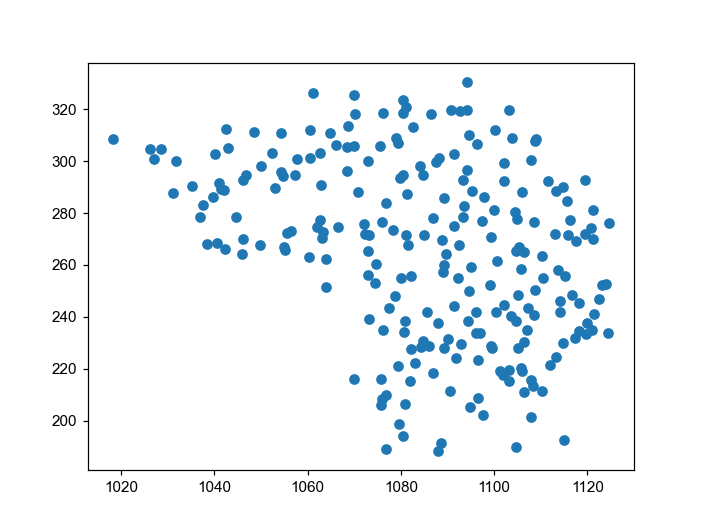

In [71]:
_sel_spots = _spots[_labels==4]

plt.figure()
plt.scatter(_sel_spots[:,3], _sel_spots[:,2])
plt.show()

## Create fov_class

In [ ]:
_fov_id = 10

dna_fov = classes.field_of_view.Field_of_View(dna_fov_param, _fov_id=_fov_id,
                                              _color_info_kwargs={
                                                  '_color_filename':'Color_Usage',
                                              }, 
                                              _prioritize_saved_attrs=False,
                                              _save_info_to_file=False,
                                              )

# create rna_fov class
rna_fov = classes.field_of_view.Field_of_View(rna_fov_param, _fov_id=_fov_id,
                                          _color_info_kwargs={
                                              '_color_filename':'Color_Usage',
                                          }, 
                                          _prioritize_saved_attrs=False,
                                          _save_info_to_file=False,
                                          )

## load dapi images

In [32]:

dna_dapi_im = dna_fov._load_dapi_image()

rna_dapi_im = rna_fov._load_dapi_image()

-- choose dapi images from folder: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\H0C1.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\H0C1\Conv_zscan_010.dax
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\H0C1\Conv_zscan_010.dax [3]
[3]
 in 4.998s
-- removing hot pixels for channels:['405'] in 7.161s
-- correct Z-shifts for channels:['405'] in 5.754s
-- illumination correction for channels: 405, in 2.215s
-- warp image with drift:[0. 0. 0.] in 0.000s
-- finish correction in 20.830s
-- saving fov_info to file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_010.hdf5
++ base attributes saved:['dapi_im'] in 6.422s.


## Translate segmentation

In [99]:
segmentation_filename = os.path.join(rna_fov.save_folder, 'Segmentation', 
                                     os.path.basename(dna_fov.save_filename).replace('.hdf5', '_Segmentation.npy'))
seg_labels = np.load(segmentation_filename)


new_label = segmentation_tools.cell.translate_segmentation(rna_fov.dapi_im, dna_fov.dapi_im,
                                               R,  seg_labels)

-- start calculating drift with rotation between images
-- aligning image -> directly use image
-- directly use ref_image
--- drift: [ 0.06 -3.79 24.95] pixels


## Partition spots into cells

In [151]:
reload(ia.meta_tools.partition_spots)
from ImageAnalysis3.meta_tools.partition_spots import Spots_Partition
from ImageAnalysis3.classes.preprocess import Spots3D

dna_fov._load_from_file('combo')

pixel_sizes = dna_fov.shared_parameters['distance_zxy']
single_im_size = dna_fov.shared_parameters['single_im_size']

all_spots_list = [Spots3D(_spots, bits=_id, pixel_sizes=pixel_sizes) for _spots, _id in zip(dna_fov.combo_spots_list, dna_fov.combo_ids)]

dapi_th = 10000
sp = Spots_Partition(new_label, "", 
                     search_radius=10, pixel_sizes=pixel_sizes,
                     save_filename=None)


cell_2_spots = {_c:{} for _c in np.unique(new_label)[np.unique(new_label)>0]}

for _spots, _id in zip(all_spots_list, dna_fov.combo_ids):
    _labels = sp.spots_to_labels(sp.segmentation_masks, _spots, sp.image_size)

    _signals = sp.spots_to_DAPI(dna_fov.dapi_im, _spots, single_im_size, search_radius=5)

    for _l in np.unique(_labels):
        if _l > 0:
            cell_2_spots[_l][_id] = _spots[(_labels==_l) * (_signals > dapi_th)]
            cell_2_spots[_l][_id].bits = _spots.bits[(_labels==_l) * (_signals > dapi_th)]

- Partition spots
- partition barcodes for 4819 spots
- calculate local DAPI signal for 4819 spots
- partition barcodes for 8507 spots
- calculate local DAPI signal for 8507 spots
- partition barcodes for 4593 spots
- calculate local DAPI signal for 4593 spots


C:\Users\puzheng\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\puzheng\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- partition barcodes for 9160 spots
- calculate local DAPI signal for 9160 spots
- partition barcodes for 5602 spots
- calculate local DAPI signal for 5602 spots
- partition barcodes for 8292 spots
- calculate local DAPI signal for 8292 spots
- partition barcodes for 4812 spots
- calculate local DAPI signal for 4812 spots
- partition barcodes for 7774 spots
- calculate local DAPI signal for 7774 spots
- partition barcodes for 4451 spots
- calculate local DAPI signal for 4451 spots
- partition barcodes for 9039 spots
- calculate local DAPI signal for 9039 spots
- partition barcodes for 4617 spots
- calculate local DAPI signal for 4617 spots
- partition barcodes for 8911 spots
- calculate local DAPI signal for 8911 spots
- partition barcodes for 5017 spots
- calculate local DAPI signal for 5017 spots
- partition barcodes for 8894 spots
- calculate local DAPI signal for 8894 spots
- partition barcodes for 4524 spots
- calculate local DAPI signal for 4524 spots
- partition barcodes for 813

## Save

In [140]:
cand_spot_folder = os.path.join(dna_fov.save_folder, 'CandSpots')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(cand_spot_folder)
    
    
# save spots
for _cell_id, _spots_list in cell_2_spots.items():
    _cand_filename = os.path.join(cand_spot_folder, os.path.basename(dna_fov.save_filename).replace('.hdf5', f'_Cell-{_cell_id}_CandSpots.pkl') )
    print(_cand_filename)
    pickle.dump(_spots_list, open(_cand_filename, 'wb'))

Creating cand_spot_folder: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots


In [89]:
cell_2_spots[1][97]

Spots3D([[ 9.33250781e+03,  4.06502819e+00,  1.53959427e+02, ...,
          -6.85464144e-01,  1.87382042e-01,  3.57839325e+02],
         [ 7.96491357e+03,  1.01121235e+01,  1.43295914e+02, ...,
          -4.64022607e-01, -8.02675188e-01,  3.92144409e+02],
         [ 7.52545166e+03,  8.63940525e+00,  6.20172119e+01, ...,
           1.00000000e+00, -4.16200012e-02,  4.94398071e+02],
         ...,
         [ 1.69390588e+03,  1.41743965e+01,  1.35555405e+02, ...,
           8.37137938e-01, -9.46749985e-01,  1.57536194e+02],
         [ 1.54867517e+03,  1.54508982e+01,  7.82783813e+01, ...,
           2.27230817e-01, -6.34249032e-01,  2.00045441e+02],
         [ 1.68306323e+03,  1.27939034e+01,  6.10809250e+01, ...,
           2.90753007e-01,  9.66998190e-02,  1.87077271e+02]],
        dtype=float32)

In [87]:
int_th =1000

cell_spots_counts = []
for _cell, _spots_dict in cell_2_spots.items():
    _spots_counts = []
    for _bit in dna_fov.combo_ids:
        if _bit in _spots_dict:
            print(np.sum(_spots_dict[_bit].to_intensities() > int_th), len(_spots_dict[_bit]))
            _spots_counts.append(np.sum(_spots_dict[_bit].to_intensities() > int_th))
        else:
            _spots_counts.append(0)
    cell_spots_counts.append(np.array(_spots_counts))
cell_spots_counts = np.array(cell_spots_counts)

137 137
187 187
137 137
206 207
135 135
182 182
139 139
183 183
144 144
177 177
151 151
205 205
145 145
177 177
235 235
185 185
149 149
207 207
146 146
187 187
161 161
190 190
164 165
185 185
160 160
178 178
137 137
193 193
159 159
156 156
186 186
162 162
161 161
190 190
163 163
161 161
142 142
173 173
159 159
175 176
150 150
173 173
152 152
176 176
147 147
156 156
144 144
181 181
220 220
351 352
183 183
205 205
128 128
167 167
146 147
154 154
131 131
174 174
135 136
174 174
141 141
177 177
113 114
162 162
124 124
173 173
137 137
174 174
125 125
176 176
141 141
162 162
157 157
168 168
135 135
171 171
147 147
160 161
137 138
164 164
147 147
177 177
165 165
145 145
142 142
189 189
141 141
175 175
121 122
168 168
131 131
188 188
128 128
162 162
108 108
187 187
100 100
169 169
130 131
75 75
93 94
72 72
91 91
74 75
110 110
73 73
77 77
75 75
96 96
74 74
115 115
66 66
95 95
71 71
111 111
88 88
85 85
71 71
92 92
73 73
98 98
76 76
98 98
77 77
91 91
78 78
97 97
81 81
96 96
84 85
87 87
77 77
96 9

96 96
107 107
106 107
119 119
95 95
109 110
82 82
115 115
80 80
108 108
82 82
112 112
74 75
106 107
75 75
115 115
56 56
95 95
72 72
12 12
13 13
17 17
20 20
17 17
18 18
13 13
15 15
14 14
22 22
20 20
23 23
18 18
19 19
31 32
15 15
18 18
19 19
15 15
18 18
19 19
26 26
12 12
16 16
17 17
16 16
15 15
16 16
12 12
18 18
19 19
18 18
17 17
22 22
20 20
20 20
16 16
18 18
20 20
20 20
20 20
21 21
19 19
18 18
15 15
13 13
20 20
21 21
30 30
44 44
25 25
21 21
18 19
17 17
18 18
14 14
10 10
19 19
10 10
14 15
17 17
23 23
17 17
27 27
15 15
10 10
11 11
15 15
7 7
21 21
14 14
11 11
16 16
20 20
12 12
22 22
19 19
14 14
11 11
17 17
20 20
19 19
17 17
18 18
13 13
21 21
23 23
17 17
16 16
18 18
14 14
30 30
15 15
16 16
15 15
21 21
9 9
24 24
12 12
2 2
4 4
0 0
0 0
0 0
0 0
0 0
0 0
3 3
1 1
0 0
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
84 84
140 140
92 92
134 134
94 94
140 141
99 99
137 137
104 104
133 133
101 101
149 149
97 97
173 174
94 94
125 125
106 106
129 129
86 86
132 132
99 99
143 143
94 95
145 145
106 106
135 135
103 104


60 60
87 87
67 67
93 93
72 72
86 86
65 65
94 94
84 84
105 105
92 92
87 88
59 59
94 95
80 80
109 109
78 78
104 104
75 75
107 107
78 79
91 91
63 63
96 96
71 71
98 98
66 66
81 81
66 66
92 93
61 61
93 93
74 74
8 8
19 19
17 17
11 11
18 18
12 12
15 15
10 10
18 18
11 11
10 10
16 16
7 7
9 9
15 15
20 20
11 11
18 18
12 12
15 15
17 17
11 11
9 9
13 13
13 13
16 16
13 13
16 16
12 12
20 20
15 15
15 15
12 12
10 10
9 9
8 8
9 9
16 16
14 14
11 11
19 19
14 14
18 18
18 18
15 15
17 17
13 13
13 13
25 25
32 32
18 18
20 20
10 10
11 11
15 15
15 15
15 15
10 10
11 11
15 15
12 12
13 13
12 12
16 16
7 7
17 17
15 15
18 18
11 11
15 15
10 10
12 12
10 10
15 15
11 11
13 13
16 16
13 13
14 14
16 16
15 15
15 15
11 11
16 17
15 15
15 15
17 17
10 10
11 11
11 11
8 8
15 15
8 8
12 12
15 15
12 12
10 10
18 18
14 14
78 78
101 101
78 78
116 116
78 78
88 88
66 66
95 95
80 80
107 107
70 70
106 107
72 72
106 106
64 64
91 91
94 94
93 93
71 71
105 105
78 78
103 103
77 77
93 93
86 88
95 95
67 67
99 100
89 89
98 98
85 85
87 87
81 81
86 86
6

48 49
79 79
51 52
59 59
55 55
74 74
37 37
85 85
56 56
0 0
0 0
0 0
0 0
0 0
0 0
0 0
88 88
115 115
79 79
132 133
68 68
107 107
85 85
106 106
90 90
120 120
83 83
109 109
85 86
112 112
71 71
101 102
86 86
99 99
90 90
109 109
79 79
98 98
82 82
113 113
91 91
108 108
78 78
111 111
84 84
96 96
108 108
110 110
86 86
114 114
83 83
108 108
90 90
90 90
94 94
100 100
76 76
96 96
80 80
97 97
74 74
102 102
84 84
91 91
164 164
270 270
124 124
130 130
84 84
109 109
90 90
87 87
71 71
117 117
76 76
104 104
72 72
88 88
65 65
92 92
64 64
101 102
69 69
83 83
79 79
80 80
82 82
89 89
82 82
105 105
72 72
102 102
75 76
95 95
79 79
83 84
74 74
102 102
89 90
108 108
83 83
110 110
83 83
109 109
62 62
100 100
82 82
99 99
58 58
80 80
53 53
105 105
57 57
87 87
63 63
64 64
94 94
79 79
96 96
72 72
86 86
86 86
93 93
81 81
89 89
68 68
86 86
69 69
105 105
75 75
88 88
71 71
83 83
78 78
89 89
78 78
93 93
73 73
96 96
74 75
84 85
76 76
87 87
86 86
84 84
88 88
79 79
77 77
87 87
82 82
78 78
67 67
87 87
85 85
85 85
88 88
94 94
69

29 29
38 38
30 30
43 43
23 23
38 38
28 29
49 49
24 24
38 38
28 29
40 40
23 23
36 36
32 33
42 42
16 16
36 36
25 25
53 53
74 74
61 61
83 83
47 47
76 76
58 59
88 88
64 64
78 78
71 71
86 86
52 52
93 93
63 63
70 70
62 62
76 76
57 57
79 79
55 55
68 68
54 54
74 74
60 60
65 65
67 67
70 70
69 69
61 61
77 77
76 76
60 60
72 72
70 71
68 68
57 57
78 78
54 54
66 66
68 68
64 64
55 55
65 65
61 61
78 78
65 65
60 60
92 94
124 124
83 83
78 78
57 58
62 62
62 63
63 63
59 59
72 72
61 62
74 74
59 59
76 76
43 43
76 76
44 44
77 77
55 55
61 61
61 61
75 75
55 55
70 70
61 61
69 69
64 64
73 73
57 57
64 64
63 63
68 68
66 66
67 67
68 68
65 65
65 65
73 73
50 50
71 71
64 64
64 65
51 51
59 59
41 41
65 65
52 54
75 75
55 56
65 65
54 54
31 31
43 43
26 26
37 37
37 37
38 38
23 23
41 41
36 36
46 46
34 34
37 37
37 37
34 34
24 24
38 38
27 27
39 39
33 33
34 34
27 27
26 26
25 25
38 38
32 32
33 33
35 35
24 24
30 31
30 30
27 27
33 33
31 31
32 32
36 36
30 30
22 22
34 34
28 28
26 26
27 27
32 32
25 25
29 29
15 15
21 21
28 28
30 30
44

36 36
24 24
30 30
22 23
27 27
24 24
22 22
16 16
31 31
23 23
40 40
21 21
30 30
34 34
31 31
27 27
32 32
22 22
34 34
22 22
26 26
24 24
30 30
40 40
50 50
27 27
36 36
18 18
35 35
17 17
26 26
25 25
23 23
22 22
27 27
20 20
29 30
15 16
22 22
23 24
35 35
20 20
28 28
25 26
30 30
16 16
25 25
20 20
28 28
20 20
31 31
32 32
22 23
19 19
27 27
25 25
30 30
22 22
24 24
27 27
32 32
18 18
36 36
21 21
34 34
24 24
33 33
24 24
23 23
26 26
28 28
13 13
19 19
19 19
49 49
87 87
60 60
79 79
58 59
93 93
67 67
77 77
60 60
82 82
67 68
104 104
52 52
79 79
57 57
76 76
54 54
66 67
69 69
82 82
58 58
84 84
55 55
85 85
59 59
76 76
62 62
82 83
63 63
77 77
57 57
70 70
56 56
63 63
61 61
67 67
53 53
79 79
70 70
59 59
55 55
91 91
57 57
74 74
49 49
64 64
57 57
79 79
78 78
131 131
72 72
90 90
41 42
75 75
52 52
81 81
51 52
73 74
51 51
63 64
53 53
59 59
44 44
53 53
48 48
76 76
55 56
72 72
63 63
68 68
57 57
73 73
51 51
80 80
53 53
72 72
57 57
55 55
57 57
69 70
69 69
62 62
65 65
76 76
61 61
62 62
58 58
72 72
50 50
62 62
55 55
65 66


16 16
0 0
6 6
2 2
4 4
6 6
13 14
5 5
4 4
3 3
9 9
4 4
8 8
2 2
7 7
7 7
4 4
4 5
7 7
4 4
10 10
1 1
9 9
5 5
9 9
1 1
4 4
9 9
6 6
2 2
9 9
3 3
7 7
0 0
5 5
2 2
5 5
1 1
4 4
10 10
5 5
8 8
6 6
7 7
0 0
8 8
8 8
6 6
3 3
11 12
1 1
10 10
3 3
7 7
4 4
5 5
6 6
12 12
3 3
7 7
1 1
9 9
4 4
8 8
6 6
10 10
5 5
10 10
4 4
8 8
6 6
3 3
7 7
10 10
6 6
12 12
3 3
8 8
6 6
8 8
4 5
5 5
6 6
9 9
1 1
3 3
4 4
18 18
2 2
9 9
1 1
10 10
2 2
5 5
2 2
9 9
3 4
10 10
4 4
7 7
2 4
7 7
3 3
5 5
2 2
7 7
5 5
10 10
5 5
9 9
5 5
9 9
4 4
6 6
2 2
3 3
6 6
7 7
8 8
9 9
1 1
3 3
1 1
6 6
4 4
1 1
2 2
1 1
7 7
2 2
6 6
1 1
12 12
9 9
1 1
10 10
7 7
8 8
12 12
6 6
8 8
6 6
11 11
6 6
10 10
10 10
6 6
5 5
10 10
5 5
9 9
5 5
10 10
8 8
13 13
5 5
13 13
6 6
12 12
6 6
9 9
4 4
8 8
6 6
8 8
4 4
7 7
4 4
5 5
6 6
4 4
6 6
12 12
5 5
7 7
5 5
5 5
6 6
8 8
5 5
6 6
7 7
6 6
10 10
19 19
4 4
12 12
5 5
8 8
8 8
7 7
5 5
7 7
7 7
8 8
3 3
6 6
2 2
7 7
5 5
6 6
2 2
5 5
10 10
7 7
7 7
12 12
8 8
8 8
3 3
7 7
3 3
5 5
6 6
7 7
5 5
12 12
6 6
11 11
7 7
8 8
7 7
10 10
6 6
5 5
5 5
7 7
5 5
5 5
4 4
5 5
2 2
6 

In [90]:

figure_folder = os.path.join(dna_fov_param['save_folder'], 'Figures')
if not os.path.exists(figure_folder):
    os.makedirs(figure_folder)

<IPython.core.display.Javascript object>


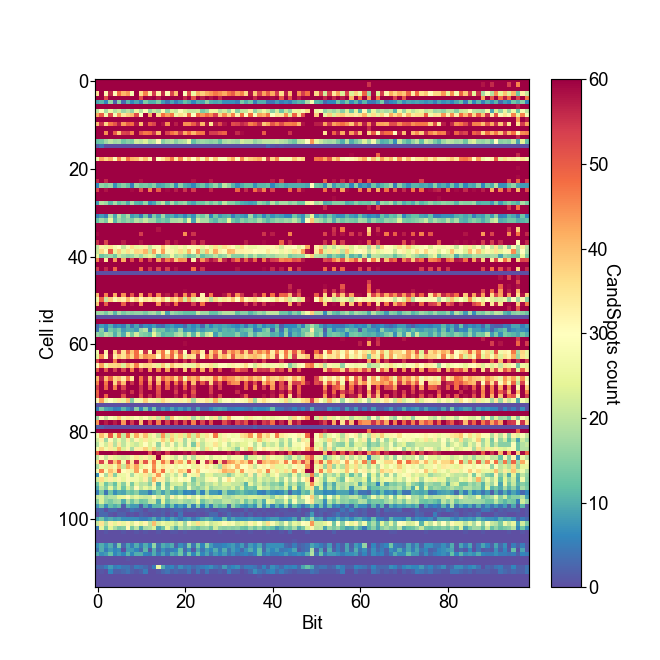

In [91]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(4,4), dpi=150, )

_pf = ax.imshow(cell_spots_counts, cmap='Spectral_r', vmin=0, vmax=60)

ax.tick_params('both', labelsize=8, 
                width=0.5, length=2,
                pad=1, labelleft=True, labelbottom=True) # remove bottom ticklabels for ax
[i[1].set_linewidth(0.5) for i in ax.spines.items()]

ax.set_xlabel('Bit', fontsize=8, labelpad=1)

ax.set_ylabel('Cell id', fontsize=8, labelpad=0)
# locate ax
divider = make_axes_locatable(ax)
# colorbar ax
cax = divider.append_axes('right', size='7%', pad="5%")
cbar = plt.colorbar(_pf,cax=cax, ax=ax, )

cbar.ax.tick_params('both', labelsize=8, 
                width=0.5, length=2,
                pad=1, labelleft=False) # remove bottom ticklabels for ax
cbar.outline.set_linewidth(0.5)
cbar.set_label('CandSpots count', 
               fontsize=8, labelpad=5, rotation=270)

fig.savefig(os.path.join(figure_folder, dna_fov.fov_name.replace('.dax', f'_SpotCounts_th-{int_th}.png')))
#fig.show()
    